# This notebook aims to fill missing data from the wildfire dataset

* [Fill `fuel_type` feature](#Fill-fuel_type-feature)
* [Fill `true_cause` feature](#Fill-true_cause-feature)
* [Fill `activity_class` feature](#Fill-activity_class-feature)
* [Fill `weather_conditions_over_fire` feature](#Fill-weather_conditions_over_fire-feature)
* [Fill `fire_position_on_slope` feature](#Fill-fire_position_on_slope-feature)
* [Fill `fire_type` feature](#Fill-fire_type-feature)


In [96]:
# All imports for the project goes here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from helpers import feature_plot, oneHotEnc_to_classes, parse_datetime_features_to_hours, RocCallback
from helpers import datetime_feature_engineering, fill_datetime_with_neighbors, save_model, load_model
from helpers import fire_number_feature_engineering, data_analysis_by_size_class
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import category_encoders as ce
from datetime import datetime
from sklearn.preprocessing import StandardScaler, RobustScaler
from helpers import feature_plot
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score, accuracy_score, make_scorer
from sklearn.model_selection import GridSearchCV


%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [97]:
# Loading the dataset
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [98]:
# Parsing date data to datetime type
dates_list = ['assessment_datetime', 'fire_start_date', 'discovered_date', 'reported_date', 'start_for_fire_date', 
             'fire_fighting_start_date', 'bh_fs_date', 'uc_fs_date', 'ex_fs_date']
train[dates_list]=pd.to_datetime(train[dates_list].stack(), format = "%Y-%m-%d %H:%M:%S").unstack()
test[dates_list]=pd.to_datetime(test[dates_list].stack(), format = "%Y-%m-%d %H:%M:%S").unstack()

In [5]:
# Train missing data
null_counts = train.isnull().sum()
null_counts[null_counts > 0].sort_values(ascending=False)

true_cause                      7194
activity_class                  6197
fuel_type                       4793
fire_fighting_start_date        4199
discovered_date                 2119
weather_conditions_over_fire    1893
fire_position_on_slope          1888
fire_type                       1819
fire_start_date                  433
fire_origin                        7
reported_date                      1
det_agent                          1
det_agent_type                     1
dtype: int64

In [4]:
# Test missing data
null_counts = test.isnull().sum()
null_counts[null_counts > 0].sort_values(ascending=False)

true_cause                      1796
activity_class                  1524
fuel_type                       1247
fire_fighting_start_date        1080
discovered_date                  546
weather_conditions_over_fire     456
fire_position_on_slope           456
fire_type                        434
fire_start_date                  112
fire_origin                        3
dtype: int64

In [6]:
# Get training data only with non null rows
noNaN_train = train.dropna()

In [7]:
datetime_feature_engineering(noNaN_train)

,fire_number,fire_year,size_class,fire_location_latitude,fire_location_longitude,fire_origin,general_cause_desc,activity_class,true_cause,det_agent_type,...,fire_type,fire_position_on_slope,weather_conditions_over_fire,fuel_type,fire_duration,time_to_ex,time_to_uc,time_to_bh2,time_to_bh,time_to_report
4,SWF001,2009,A,55.905933,-113.578850,Indian Reservation,Resident,Piles,Permit Related,UNP,...,Surface,Flat,Clear,C2,1395.0,1161.0,0.0,114.0,234.0,0.0
41,SWF216,2009,B,54.932783,-115.210783,Provincial Land,Power Line Industry,Power Lines,Unpredictable Event,UNP,...,Surface,Flat,Cloudy,C2,1253.0,1203.0,963.0,42.0,50.0,0.0
44,HWF044,2006,B,58.496423,-115.123148,Indian Reservation,Resident,Grass,Permit Related,LKT,...,Surface,Flat,Clear,O1a,1155.0,1115.0,1055.0,0.0,40.0,3.0
53,HWF036,2009,A,58.720683,-118.696617,Indian Reservation,Resident,Children,Burning Substance,UNP,...,Surface,Flat,Clear,O1a,2269.0,2267.0,0.0,0.0,2.0,0.0
68,HWF034,2011,B,58.452807,-114.579165,Indian Reservation,Resident,Grass,Permit Related,LKT,...,Surface,Flat,CB Dry,O1a,2660.0,2610.0,10.0,10.0,50.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15847,LWF009,2013,B,55.917117,-110.736367,Indian Reservation,Resident,Debris Disposal,Unsafe Fire,LKT,...,Surface,Flat,Clear,O1a,1188.0,1147.0,104.0,0.0,41.0,2.0
15859,SWF050,2008,C,55.464667,-114.796350,Provincial Park,Power Line Industry,Power Lines,Unpredictable Event,LKT,...,Crown,Middle 1/3,Cloudy,M2,54342.0,51810.0,1912.0,2380.0,2532.0,2.0
15861,GWF159,2008,A,54.859544,-118.777492,Provincial Land,Power Line Industry,Power Lines,Insufficient Buffer,UNP,...,Surface,Flat,Clear,O1b,142.0,5.0,0.0,-1.0,137.0,0.0
15863,SWF202,2006,A,55.949617,-113.730433,Provincial Land,Recreation,All Terrain Vehicles,Hot Exhaust,LKT,...,Surface,Flat,Clear,M2,935.0,865.0,65.0,25.0,70.0,0.0


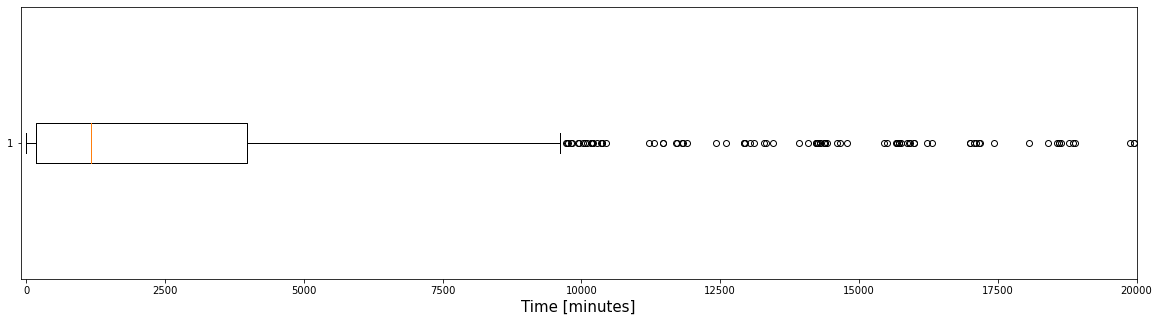

In [210]:
plt.figure(figsize=(20,5))
plt.boxplot(datetime_feature_engineering(noNaN_train)['fire_duration'], vert=False)
plt.xlabel('Time [minutes]', fontsize=15)
plt.xlim([-100,20000]);

In [211]:
#plt.figure(figsize=(20,5))
#plt.boxplot(datetime_feature_engineering(noNaN_train)['time_to_ex'], vert=False);
#plt.xlabel('Time [minutes]', fontsize=15)
#plt.xlim([-100,20000]);

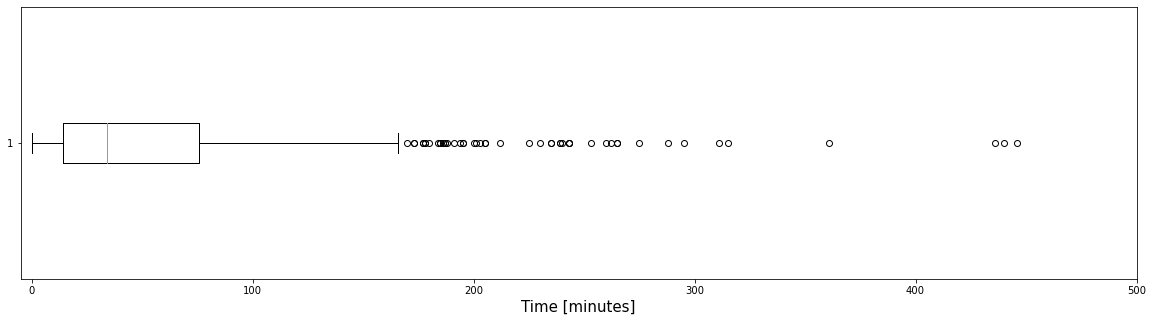

In [212]:
plt.figure(figsize=(20,5))
plt.boxplot(datetime_feature_engineering(noNaN_train)['fire_fight_response_time'], vert=False);
plt.xlabel('Time [minutes]', fontsize=15)
plt.xlim([-5,500]);

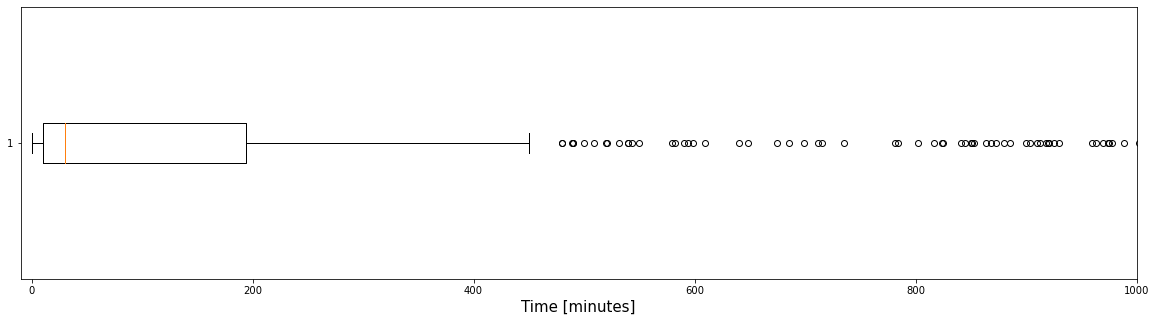

In [213]:
plt.figure(figsize=(20,5))
plt.boxplot(datetime_feature_engineering(noNaN_train)['time_to_discover'], vert=False);
plt.xlabel('Time [minutes]', fontsize=15)
plt.xlim([-10,1000]);

In [214]:
# Get training data only with non null rows
noNaN_test = test.dropna()
datetime_feature_engineering(noNaN_test)

,fire_number,fire_year,fire_location_latitude,fire_location_longitude,fire_origin,general_cause_desc,activity_class,true_cause,det_agent_type,det_agent,initial_action_by,fire_type,fire_position_on_slope,weather_conditions_over_fire,fuel_type,fire_duration,time_to_ex,fire_fight_response_time,time_to_discover,time_to_report
1,WWF031,2008,54.186250,-115.175200,Provincial Land,Recreation,All Terrain Vehicles,Burning Substance,LKT,IM,HAC1H,Surface,Flat,Clear,M2,2719.0,2590.0,60.0,15.0,0.0
17,RWF051,2009,52.462913,-115.095227,Provincial Land,Power Line Industry,Power Lines,Insufficient Buffer,LKT,RY,FPD Staff,Surface,Flat,Cloudy,O1a,444.0,328.0,28.0,83.0,0.0
31,CWF117,2018,51.142300,-114.721217,Provincial Land,Resident,Transportation,Vehicle Fire,GRP,PATR,FPD Staff,Surface,Flat,Cloudy,O1b,50.0,20.0,0.0,10.0,0.0
32,CWF209,2016,50.184933,-114.319600,Provincial Land,Recreation,Cooking and Warming,Unsafe Fire,UNP,LFS,FPD Staff,Surface,Bottom,Clear,D1,2674.0,1594.0,1041.0,39.0,0.0
33,PWF010,2010,56.477417,-116.414167,Provincial Land,Resident,Children,Burning Substance,UNP,LFS,FPD Staff,Ground,Flat,Clear,O1a,398.0,181.0,22.0,195.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3945,LWF008,2012,55.931817,-110.725767,Indian Reservation,Resident,Debris Disposal,Unsafe Fire,UNP,LFS,FPD Staff,Surface,Flat,Clear,O1b,1180.0,1122.0,2.0,58.0,0.0
3947,SWF123,2010,55.636133,-116.402533,Provincial Land,Resident,Unclassified,Unattended Fire,UNP,310,HAC1H,Surface,Flat,CB Dry,M2,2440.0,1217.0,19.0,1205.0,0.0
3959,HWF017,2008,58.717650,-118.746317,Indian Reservation,Resident,Grass,Abandoned Fire,LKT,ZA,HAC1H,Surface,Flat,Cloudy,O1a,264.0,126.0,114.0,26.0,0.0
3960,MWF005,2016,56.163967,-111.744100,Provincial Land,Other Industry,Debris Disposal,Winter Burning,LKT,AL,HAC,Surface,Flat,Clear,S1,102381.0,1311.0,71.0,101014.0,0.0


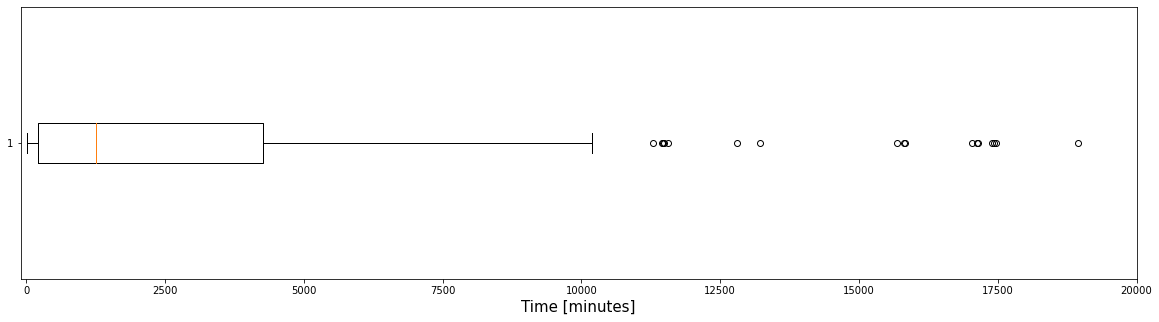

In [215]:
plt.figure(figsize=(20,5))
plt.boxplot(datetime_feature_engineering(noNaN_test)['fire_duration'], vert=False)
plt.xlabel('Time [minutes]', fontsize=15)
plt.xlim([-100,20000]);

In [216]:
#plt.figure(figsize=(20,5))
#plt.boxplot(datetime_feature_engineering(noNaN_test)['time_to_ex'], vert=False);
#plt.xlabel('Time [minutes]', fontsize=15)
#plt.xlim([-100,20000]);

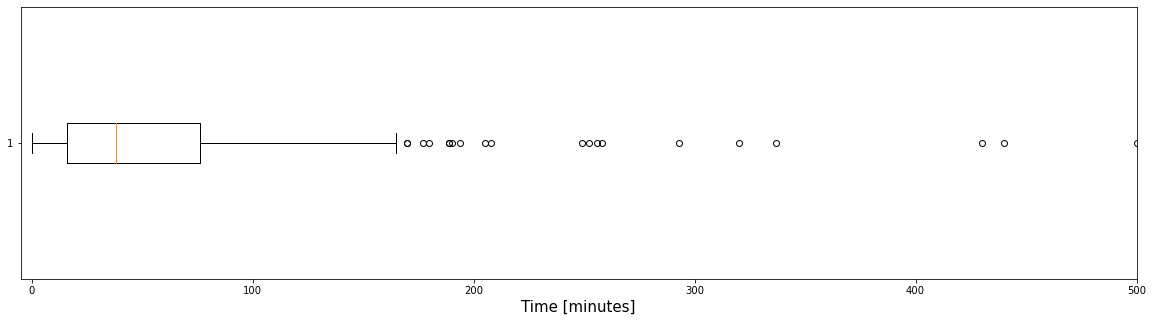

In [217]:
plt.figure(figsize=(20,5))
plt.boxplot(datetime_feature_engineering(noNaN_test)['fire_fight_response_time'], vert=False);
plt.xlabel('Time [minutes]', fontsize=15)
plt.xlim([-5,500]);

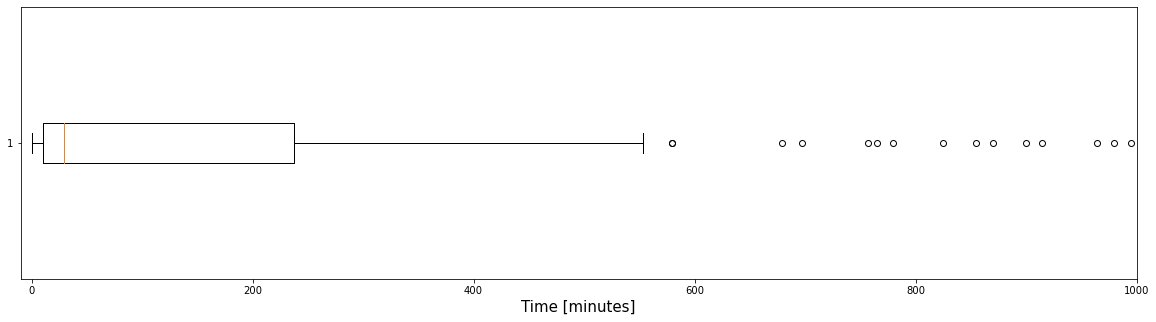

In [218]:
plt.figure(figsize=(20,5))
plt.boxplot(datetime_feature_engineering(noNaN_test)['time_to_discover'], vert=False);
plt.xlabel('Time [minutes]', fontsize=15)
plt.xlim([-10,1000]);

# Fill `fuel_type` feature
## Build model

In [99]:
# Train missing data
null_counts = train.isnull().sum()
null_counts[null_counts > 0].sort_values(ascending=False)

true_cause                      7194
activity_class                  6197
fuel_type                       4793
fire_fighting_start_date        4199
discovered_date                 2119
weather_conditions_over_fire    1893
fire_position_on_slope          1888
fire_type                       1819
fire_start_date                  433
fire_origin                        7
reported_date                      1
det_agent                          1
det_agent_type                     1
dtype: int64

**Note:** One of the highest unknown featues is the fuel_type which represents The predominate fuel type (vegetation cover) in which the wildfire is burning, at the time of initial assessment. The classes of this feature can be the following:

Group: Coniferous
* `C1:` Spruce-Lichen Woodland
* `C2:` Boreal Spruce
* `C3:` Mature Jack or Lodgepole Pine
* `C4:` Immature Jack or Lodgepole Pine
* `C7:` Conifer plantation

Group: Mixedwood
* `M1:` Boreal Mixedwood-Leafless
* `M2:` Boreal Mixedwood-Green

Group: Slash
* `S1:` Jack or Lodgepole Pine slash
* `S2:` White Spruce-Balsam slash

Group: Deciduous
* `D1:` Leafless Aspen

Group: Grass
* `O1a:` Matted Grass
* `O1b:` Standing Grass

In [100]:
# train non null fuel indexes
nan_fuel_indx_train = ~train['fuel_type'].isnull()
# test non null fuel indexes
nan_fuel_indx_test = ~test['fuel_type'].isnull()
## join the datasets: train + test datasets
full_dataset = pd.concat([train.drop(['size_class'], 1)[nan_fuel_indx_train], 
           test[nan_fuel_indx_test]])
## Get the features and labels
X = full_dataset.drop(['fuel_type'], 1)
y = full_dataset['fuel_type']

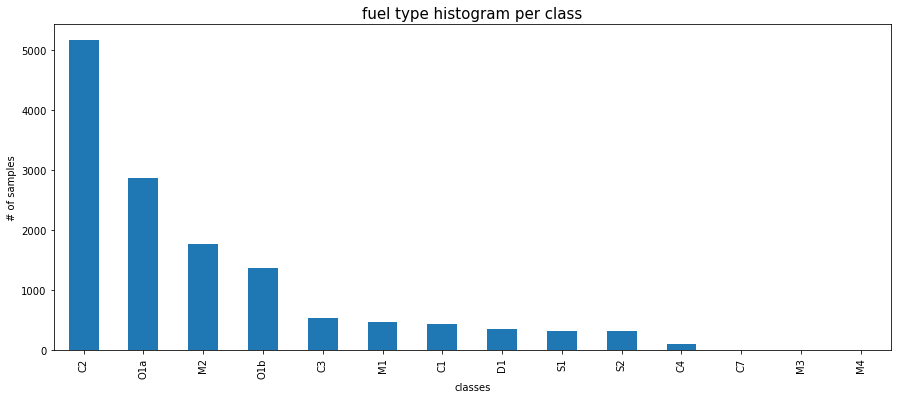

C2     5173
O1a    2878
M2     1776
O1b    1380
C3      538
M1      478
C1      446
D1      350
S1      331
S2      329
C4      112
C7       10
M3        2
M4        1
Name: fuel_type, dtype: int64

In [101]:
plt.figure(figsize=(15,6))
full_dataset['fuel_type'].value_counts().plot(kind='bar');
plt.title('fuel type histogram per class', fontsize=15);
plt.xlabel('classes')
plt.ylabel('# of samples');
plt.show()
full_dataset['fuel_type'].value_counts()

In [102]:
## Fill unknown data
fill_datetime_with_neighbors(X)
X.fillna('Unknown', inplace=True)

In [103]:
## feature engineering
X = datetime_feature_engineering(X)
X = fire_number_feature_engineering(X)
X.drop(['fire_number'], 1, inplace=True)

In [104]:
# One hot encode data
ohe = ce.OneHotEncoder(handle_unknown='value', use_cat_names=True)
X = ohe.fit_transform(X)

In [105]:
# standarized dataset
standardize = RobustScaler()
X[X.columns]=standardize.fit_transform(X)

In [106]:
# get rid of very low classes
no_M4_M3_C7_indx = (y!='M4') & (y!='M3') &((y!='C7'))

In [16]:
train_X, validation_X, train_y, validation_y = train_test_split(X[no_M4_M3_C7_indx], y[no_M4_M3_C7_indx], 
                                                                test_size=0.25, random_state=2, 
                                                                stratify=y[no_M4_M3_C7_indx])

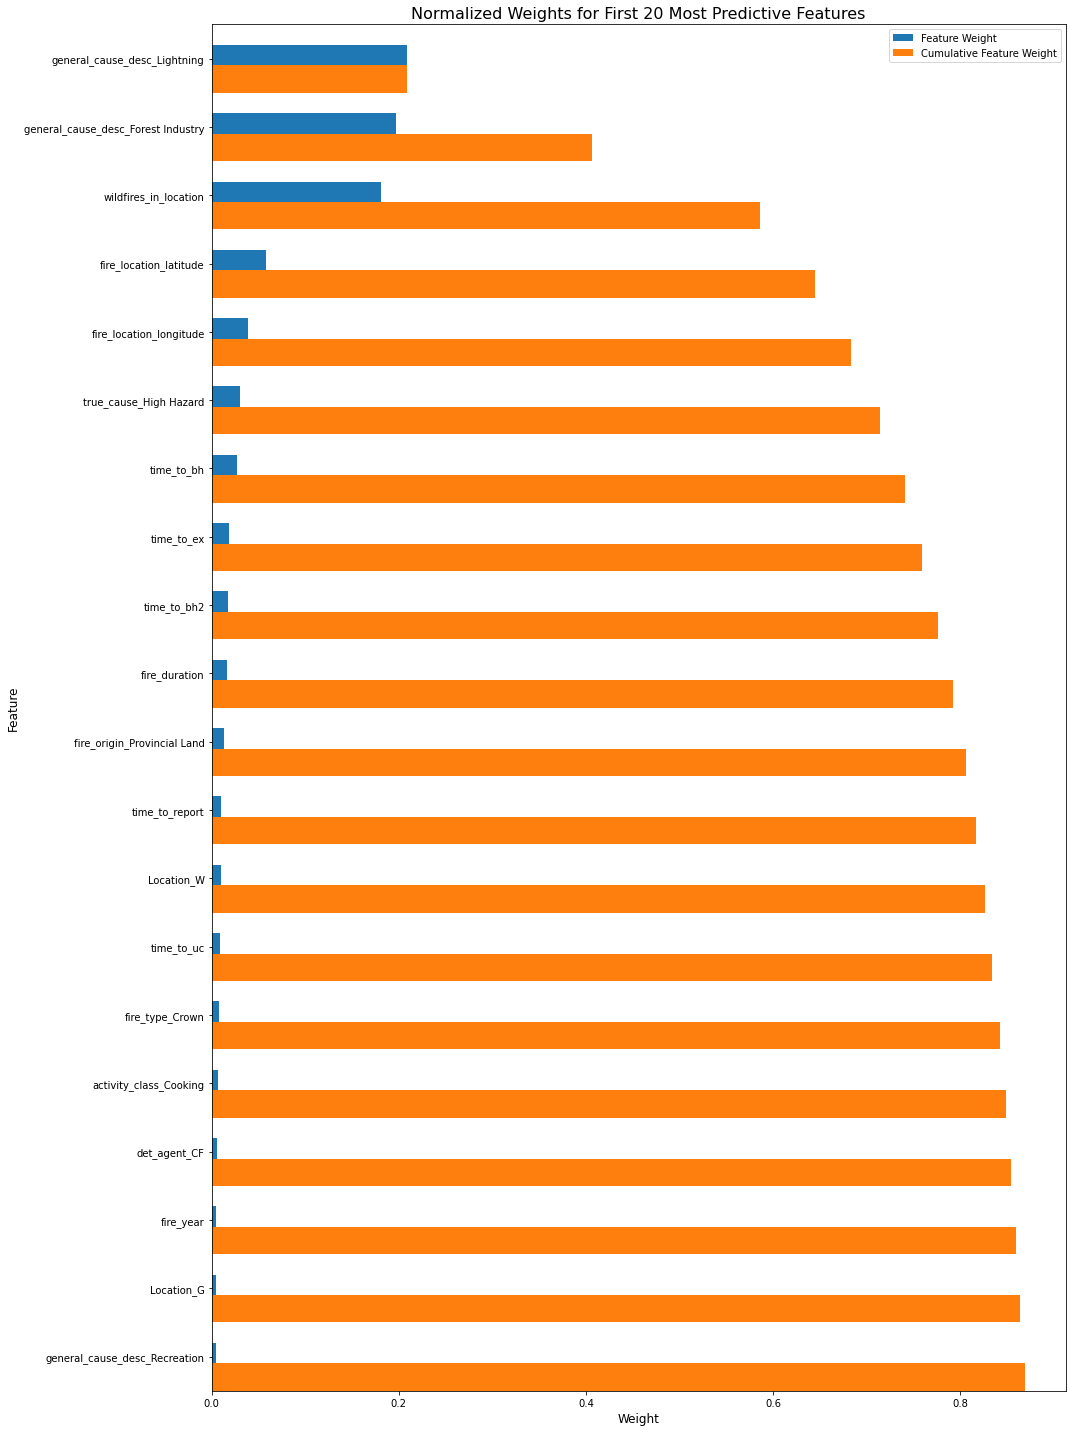

,Features,Importance value
0,general_cause_desc_Lightning,0.208832
1,general_cause_desc_Forest Industry,0.197058
2,wildfires_in_location,0.180390
3,fire_location_latitude,0.058429
4,fire_location_longitude,0.038655
5,true_cause_High Hazard,0.030272
6,time_to_bh,0.027318
7,time_to_ex,0.018052
8,time_to_bh2,0.017129
9,fire_duration,0.016429


In [17]:
model = GradientBoostingClassifier(random_state=42, learning_rate=0.5, n_estimators=50, 
                                   max_depth=3)
model.fit(train_X.values, train_y.values.ravel())

# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
relevant_df = feature_plot(importances, train_X, train_y, top_k=20)
relevant_df

In [130]:
from sklearn.decomposition import PCA
pca = PCA(n_components=25)
pca_X = pca.fit_transform(X[no_M4_M3_C7_indx])
pca = PCA(n_components=25)
pca_train_split_X = pca.fit_transform(train_X)
pca_validation_split_X =  pca.transform(validation_X)

In [107]:
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier, RUSBoostClassifier
from imblearn.metrics import geometric_mean_score
# define model
"""Best model so far"""
#model = RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced_subsample',
#                              criterion='entropy', max_features=20, min_impurity_decrease=0.003) 
""""""
#weights = {'C4': 1, 'S2': 1.8, 'S1': 3, 'D1': 3.75, 'C1': 9.6,
#           'M1': 10.8, 'C3': 11.6, 'O1b': 14.8, 'M2':15.63, 'O1a':15.72, 'C2':46.18}
#weights = {'C4': 10, 'S2': 11.8, 'S1': 14, 'D1': 15.75, 'C1': 9.6,
#           'M1': 20.8, 'C3': 17.6, 'O1b': 14.8, 'M2':29.63, 'O1a':15.72, 'C2':16.18}

#model = BalancedRandomForestClassifier(n_estimators=150, max_depth=10,
#                                       random_state=42, class_weight=weights,n_jobs = 1,
#                                      criterion='entropy', max_features=None, min_impurity_decrease=0.003
#                                      ,min_samples_leaf = 5, ccp_alpha=0.008, sampling_strategy= 'all')
#model = EasyEnsembleClassifier(base_estimator=GradientBoostingClassifier(random_state=42, learning_rate=0.5, 
#                                                                         n_estimators=100, max_depth=3,
#                                                                        max_features=15), 
#                                n_estimators=10, random_state=42)
#model = RUSBoostClassifier(random_state=42,  learning_rate=0.1, n_estimators=50)
#model = RUSBoostClassifier(base_estimator=RandomForestClassifier(class_weight = 'balanced_subsample', max_depth=10,
#                                                                criterion='entropy', max_features=15),
#                           random_state=42,  learning_rate=0.1, n_estimators=10)
model = RUSBoostClassifier(RandomForestClassifier(random_state=42, n_estimators=100, 
                                   max_depth=10, class_weight = 'balanced_subsample',
                              criterion='entropy', max_features=None, min_impurity_decrease=0.003),
                           random_state=42,  learning_rate=0.1, n_estimators=10)


# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

# evaluate model
scores = cross_val_score(model, X[no_M4_M3_C7_indx], y[no_M4_M3_C7_indx], scoring='f1_macro', cv=cv, n_jobs=-1)
#scores = cross_val_score(model, pca_X, y[no_M4_M3_C7_indx], scoring='f1_macro', cv=cv, n_jobs=-1)
# summarize performance
print('Mean f1-score: %.3f' % np.mean(scores))

Mean f1-score: 0.307


In [133]:
## Fit model
model.fit(train_X, train_y.values.ravel())

## predict using fit model
pred_validation_y = model.predict(validation_X)
f1_score = fbeta_score(validation_y.values.ravel(), pred_validation_y, beta = 1, average='macro')
gmean_score = geometric_mean_score(validation_y.values.ravel(), pred_validation_y)
gmean_score_sparse = geometric_mean_score(validation_y.values.ravel(), pred_validation_y, average=None)
print(f"F1-score - validation:{f1_score}")
print(f"Geometric mean - validation:{gmean_score}")
print(f"Geometric mean per class - validation:{gmean_score_sparse}")

print("-------------------------------------------------------------------------------------------")
pred_train_y = model.predict(train_X)
f1_score = fbeta_score(train_y.values.ravel(), pred_train_y, beta = 1, average='macro')
gmean_score = geometric_mean_score(train_y.values.ravel(), pred_train_y)
gmean_score_sparse = geometric_mean_score(train_y.values.ravel(), pred_train_y, average=None)
print(f"F1-score - train:{f1_score}")
print(f"Geometric mean - train:{gmean_score}")
print(f"Geometric mean per class - train:{gmean_score_sparse}")

F1-score - validation:0.31460781009422606
Geometric mean - validation:0.3549685402201809
Geometric mean per class - validation:[0.58156904 0.65713075 0.62962812 0.53272208 0.5358808  0.48760169
 0.52318532 0.67292774 0.59155173 0.51773537 0.66177666]
-------------------------------------------------------------------------------------------
F1-score - train:0.4241216869235656
Geometric mean - train:0.5128515875158052
Geometric mean per class - train:[0.64864323 0.67630565 0.69379977 0.89017409 0.75249901 0.64716854
 0.563376   0.67823543 0.66241678 0.71746316 0.7832119 ]


In [115]:
y[no_M4_M3_C7_indx].values

array(['C2', 'C2', 'C2', ..., 'C3', 'C3', 'O1a'], dtype=object)

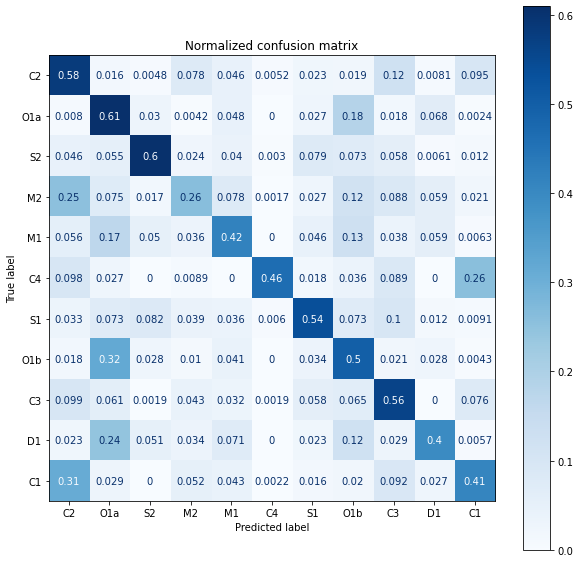

In [117]:
from sklearn.metrics import plot_confusion_matrix

model.fit(X[no_M4_M3_C7_indx], y[no_M4_M3_C7_indx].values.ravel())

class_names = y[no_M4_M3_C7_indx].unique()

# Plot non-normalized and normalized confusion matrices
titles_options = [("Normalized confusion matrix", 'true')]

fig, ax = plt.subplots(figsize=(10, 10))
for title, normalize in titles_options:
    disp = plot_confusion_matrix(model, X[no_M4_M3_C7_indx], y[no_M4_M3_C7_indx].values.ravel(),
                                 labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize, ax=ax)
    disp.ax_.set_title(title)

plt.show()

## Predicting on missing data to fill their values

In [118]:
# null fuel_type indexes for training dataset
nan_fuel_indx_train = train['fuel_type'].isnull()
# null fuel_type indexes for testing dataset
nan_fuel_indx_test = test['fuel_type'].isnull()

In [119]:
## Preprocess data
train_features = train.drop(['size_class', 'fuel_type'], 1)[nan_fuel_indx_train]
test_features = test.drop(['fuel_type'], 1)[nan_fuel_indx_test]

## Fill unknown data
fill_datetime_with_neighbors(train_features)
train_features.fillna('Unknown', inplace=True)

fill_datetime_with_neighbors(test_features)
test_features.fillna('Unknown', inplace=True)

## feature engineering
train_features = datetime_feature_engineering(train_features)
train_features = fire_number_feature_engineering(train_features)
train_features.drop(['fire_number'], 1, inplace=True)

test_features = datetime_feature_engineering(test_features)
test_features = fire_number_feature_engineering(test_features)
test_features.drop(['fire_number'], 1, inplace=True)

## One hot encode data
#ohe = ce.OneHotEncoder(handle_unknown='value', use_cat_names=True)
train_features = ohe.transform(train_features)
test_features = ohe.transform(test_features)

## standarized dataset
standardize = RobustScaler()
train_features[train_features.columns]=standardize.fit_transform(train_features)

standardize = RobustScaler()
test_features[test_features.columns]=standardize.fit_transform(test_features)

In [120]:
inx = [s not in train_X.columns for s in train_features.columns]
train_features.columns[inx]

Index(['activity_class_Unknown', 'true_cause_Unknown',
       'weather_conditions_over_fire_Cloudy',
       'weather_conditions_over_fire_CB Dry',
       'weather_conditions_over_fire_Clear',
       'weather_conditions_over_fire_CB Wet',
       'weather_conditions_over_fire_Rainshowers',
       'weather_conditions_over_fire_Unknown'],
      dtype='object')

In [121]:
## predicting values
pred_train = model.predict(train_features)
pred_test = model.predict(test_features)

In [122]:
pd.DataFrame({'test':pred_test})['test'].value_counts()

C2    407
M2    375
C1    242
C3    181
S1     35
S2      6
M1      1
Name: test, dtype: int64

In [123]:
pd.DataFrame({'train':pred_train})['train'].value_counts()

C2    1623
M2    1467
C1     890
C3     669
S1     121
M1      12
S2       9
D1       2
Name: train, dtype: int64

In [124]:
# Saving the model
save_model('./fuel_model3.pkl', model)

In [125]:
# Loading the model
model2 = load_model('./fuel_model3.pkl')

In [126]:
test_prr = model2.predict(test_features)
pd.DataFrame({'test2':test_prr})['test2'].value_counts()

C2    407
M2    375
C1    242
C3    181
S1     35
S2      6
M1      1
Name: test2, dtype: int64

## fill dataset and save it with model

In [127]:
## non null indexes
non_null_indx_train = ~train['fuel_type'].isnull()
non_null_indx_test = ~test['fuel_type'].isnull()

In [128]:
## null indexes
null_indx_train = train['fuel_type'].isnull()
null_indx_test = test['fuel_type'].isnull()

#### Non null data

In [129]:
train[non_null_indx_train].fuel_type.value_counts()

C2     4125
O1a    2325
M2     1435
O1b    1127
C3      428
M1      378
C1      364
D1      278
S2      269
S1      253
C4       89
C7        8
M3        2
M4        1
Name: fuel_type, dtype: int64

In [130]:
test[non_null_indx_test].fuel_type.value_counts()

C2     1048
O1a     553
M2      341
O1b     253
C3      110
M1      100
C1       82
S1       78
D1       72
S2       60
C4       23
C7        2
Name: fuel_type, dtype: int64

#### Null data

In [131]:
train[null_indx_train].fuel_type.isnull().value_counts()

True    4793
Name: fuel_type, dtype: int64

In [132]:
test[null_indx_test].fuel_type.isnull().value_counts()

True    1247
Name: fuel_type, dtype: int64

### Filling data

In [133]:
train.loc[null_indx_train, 'fuel_type'] = model.predict(train_features)
test.loc[null_indx_test, 'fuel_type'] = model.predict(test_features)

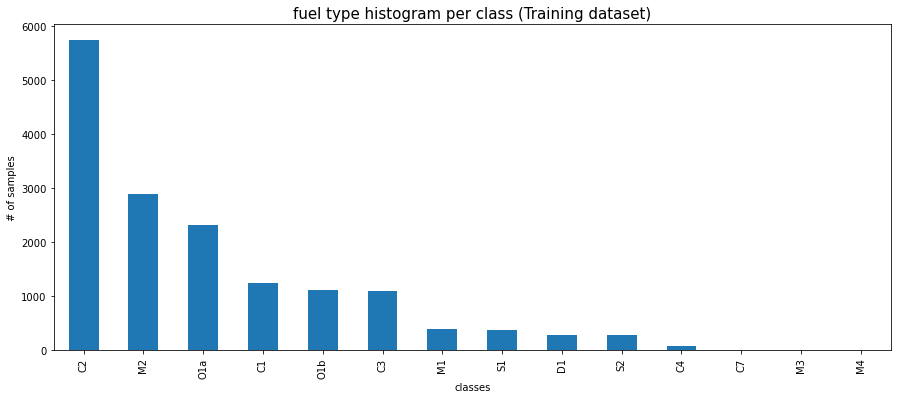

C2     5748
M2     2902
O1a    2325
C1     1254
O1b    1127
C3     1097
M1      390
S1      374
D1      280
S2      278
C4       89
C7        8
M3        2
M4        1
Name: fuel_type, dtype: int64

In [134]:
plt.figure(figsize=(15,6))
train['fuel_type'].value_counts().plot(kind='bar');
plt.title('fuel type histogram per class (Training dataset)', fontsize=15);
plt.xlabel('classes')
plt.ylabel('# of samples');
plt.show()
train['fuel_type'].value_counts()

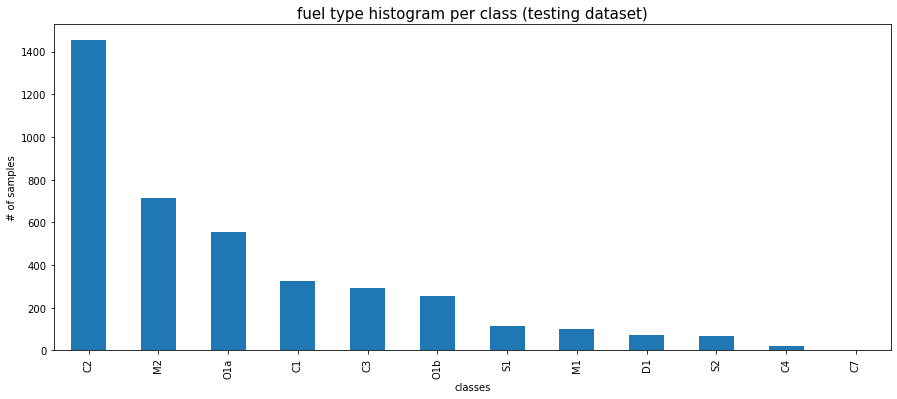

C2     1455
M2      716
O1a     553
C1      324
C3      291
O1b     253
S1      113
M1      101
D1       72
S2       66
C4       23
C7        2
Name: fuel_type, dtype: int64

In [135]:
plt.figure(figsize=(15,6))
test['fuel_type'].value_counts().plot(kind='bar');
plt.title('fuel type histogram per class (testing dataset)', fontsize=15);
plt.xlabel('classes')
plt.ylabel('# of samples');
plt.show()
test['fuel_type'].value_counts()

## saving data back to csv Files

In [136]:
file_name = 'train_fuel3.csv'
train.to_csv(file_name, encoding='utf-8', index=False)

In [137]:
file_name = 'test_fuel3.csv'
test.to_csv(file_name, encoding='utf-8', index=False)

# Fill `true_cause` feature
## Build model

In [138]:
# Loading the dataset
train = pd.read_csv('train_fuel3.csv')
test = pd.read_csv('test_fuel3.csv')
# Parsing date data to datetime type
dates_list = ['assessment_datetime', 'fire_start_date', 'discovered_date', 'reported_date', 'start_for_fire_date', 
             'fire_fighting_start_date', 'bh_fs_date', 'uc_fs_date', 'ex_fs_date']
train[dates_list]=pd.to_datetime(train[dates_list].stack(), format = "%Y-%m-%d %H:%M:%S").unstack()
test[dates_list]=pd.to_datetime(test[dates_list].stack(), format = "%Y-%m-%d %H:%M:%S").unstack()

In [139]:
# Train missing data
null_counts = train.isnull().sum()
null_counts[null_counts > 0].sort_values(ascending=False)

true_cause                      7194
activity_class                  6197
fire_fighting_start_date        4199
discovered_date                 2119
weather_conditions_over_fire    1893
fire_position_on_slope          1888
fire_type                       1819
fire_start_date                  433
fire_origin                        7
reported_date                      1
det_agent                          1
det_agent_type                     1
dtype: int64

In [140]:
# train non null fuel indexes
nan_trueCause_indx_train = ~train['true_cause'].isnull()
# test non null fuel indexes
nan_trueCause_indx_test = ~test['true_cause'].isnull()
## join the datasets: train + test datasets
full_dataset = pd.concat([train.drop(['size_class'], 1)[nan_trueCause_indx_train], 
           test[nan_trueCause_indx_test]])
## Get the features and labels
X = full_dataset.drop(['true_cause'], 1)
y = full_dataset['true_cause']

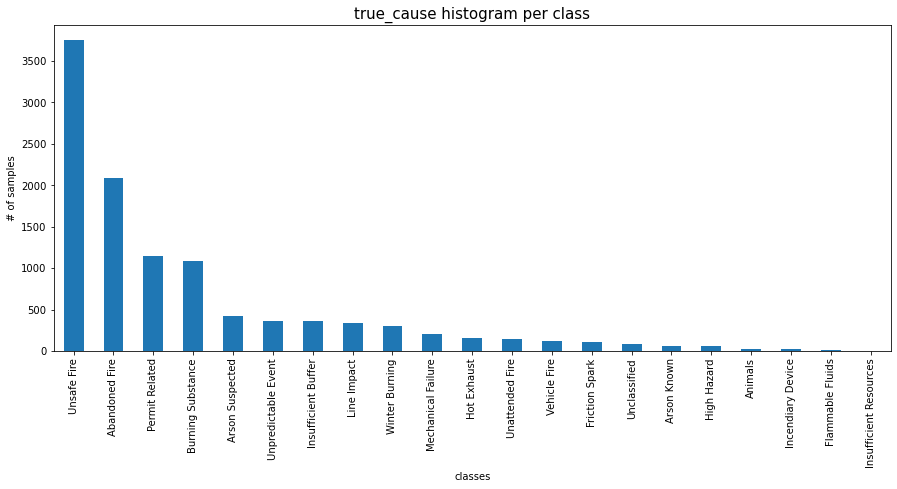

Unsafe Fire               3747
Abandoned Fire            2084
Permit Related            1147
Burning Substance         1089
Arson Suspected            423
Unpredictable Event        363
Insufficient Buffer        361
Line Impact                343
Winter Burning             300
Mechanical Failure         203
Hot Exhaust                155
Unattended Fire            143
Vehicle Fire               117
Friction Spark             108
Unclassified                83
Arson Known                 59
High Hazard                 58
Animals                     25
Incendiary Device           25
Flammable Fluids            17
Insufficient Resources       4
Name: true_cause, dtype: int64

In [141]:
plt.figure(figsize=(15,6))
full_dataset['true_cause'].value_counts().plot(kind='bar');
plt.title('true_cause histogram per class', fontsize=15);
plt.xlabel('classes')
plt.ylabel('# of samples');
plt.show()
full_dataset['true_cause'].value_counts()

In [142]:
## Fill unknown data
fill_datetime_with_neighbors(X)
X.fillna('Unknown', inplace=True)
## feature engineering
X = datetime_feature_engineering(X)
X = fire_number_feature_engineering(X)
X.drop(['fire_number'], 1, inplace=True)
# One hot encode data
ohe = ce.OneHotEncoder(handle_unknown='value', use_cat_names=True)
X = ohe.fit_transform(X)
# standarized dataset
standardize = RobustScaler()
X[X.columns]=standardize.fit_transform(X)
# get rid of very low classes
no_Insfficnt_Resrcs_indx = (y!='Insufficient Resources')
train_X, validation_X, train_y, validation_y = train_test_split(X[no_Insfficnt_Resrcs_indx], 
                                                                y[no_Insfficnt_Resrcs_indx], 
                                                                test_size=0.25, random_state=2, 
                                                                stratify=y[no_Insfficnt_Resrcs_indx])

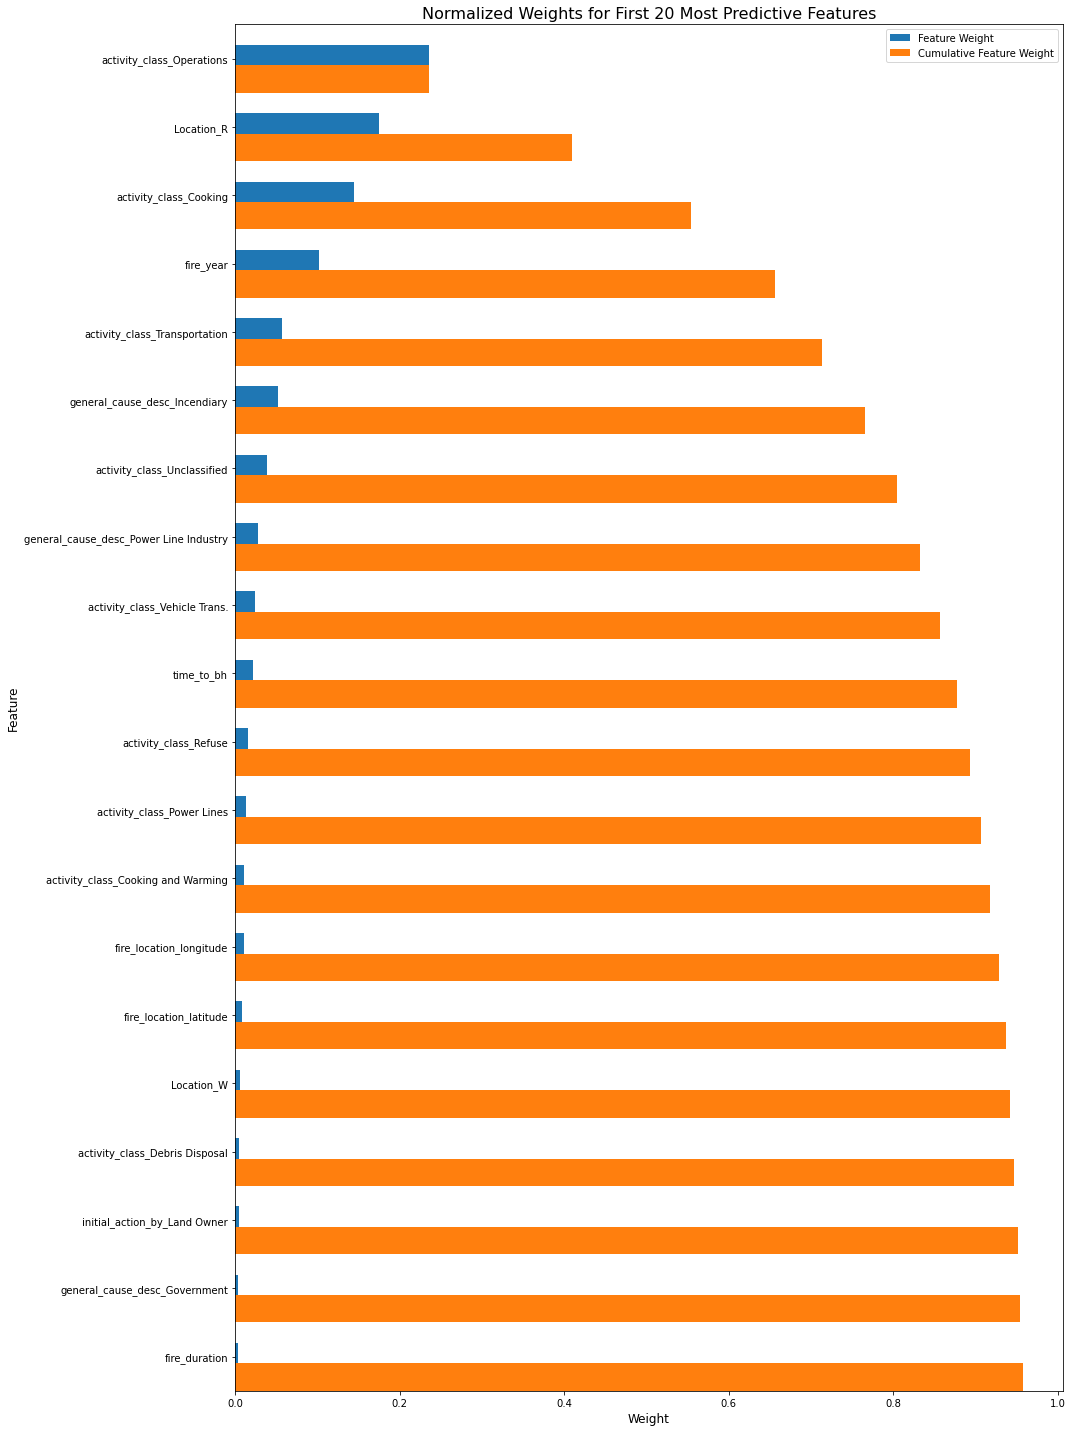

,Features,Importance value
0,activity_class_Operations,0.235322
1,Location_R,0.174755
2,activity_class_Cooking,0.144315
3,fire_year,0.102281
4,activity_class_Transportation,0.056566
5,general_cause_desc_Incendiary,0.052579
6,activity_class_Unclassified,0.038674
7,general_cause_desc_Power Line Industry,0.028291
8,activity_class_Vehicle Trans.,0.023638
9,time_to_bh,0.021465


In [22]:
model = GradientBoostingClassifier(random_state=42, learning_rate=0.5, n_estimators=50, 
                                   max_depth=3)
model.fit(train_X.values, train_y.values.ravel())

# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
relevant_df = feature_plot(importances, train_X, train_y, top_k=20)
relevant_df

In [143]:
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier, RUSBoostClassifier
from imblearn.metrics import geometric_mean_score
# define model
"""Best model so far"""
#model = RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced_subsample',
#                              criterion='entropy', max_features=20, min_impurity_decrease=0.003) 
""""""
#weights = {'C4': 1, 'S2': 1.8, 'S1': 3, 'D1': 3.75, 'C1': 9.6,
#           'M1': 10.8, 'C3': 11.6, 'O1b': 14.8, 'M2':15.63, 'O1a':15.72, 'C2':46.18}
#weights = {'C4': 10, 'S2': 11.8, 'S1': 14, 'D1': 15.75, 'C1': 9.6,
#           'M1': 20.8, 'C3': 17.6, 'O1b': 14.8, 'M2':29.63, 'O1a':15.72, 'C2':16.18}

#model = BalancedRandomForestClassifier(n_estimators=150, max_depth=10,
#                                       random_state=42, class_weight=weights,n_jobs = 1,
#                                      criterion='entropy', max_features=None, min_impurity_decrease=0.003
#                                      ,min_samples_leaf = 5, ccp_alpha=0.008, sampling_strategy= 'all')
#model = EasyEnsembleClassifier(base_estimator=GradientBoostingClassifier(random_state=42, learning_rate=0.5, 
#                                                                         n_estimators=100, max_depth=3,
#                                                                        max_features=15), 
#                                n_estimators=10, random_state=42)
#model = RUSBoostClassifier(random_state=42,  learning_rate=0.1, n_estimators=50)
#model = RUSBoostClassifier(base_estimator=RandomForestClassifier(class_weight = 'balanced_subsample', max_depth=10,
#                                                                criterion='entropy', max_features=15),
#                           random_state=42,  learning_rate=0.1, n_estimators=10)
model = RUSBoostClassifier(RandomForestClassifier(random_state=42, n_estimators=100, 
                                   max_depth=10, class_weight = 'balanced_subsample',
                              criterion='entropy', max_features=None, min_impurity_decrease=0.003),
                           random_state=42,  learning_rate=0.1, n_estimators=10)


# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

# evaluate model
scores = cross_val_score(model, X[no_Insfficnt_Resrcs_indx], y[no_Insfficnt_Resrcs_indx], scoring='f1_macro', cv=cv, n_jobs=-1)
#scores = cross_val_score(model, pca_X, y[no_M4_M3_C7_indx], scoring='f1_macro', cv=cv, n_jobs=-1)
# summarize performance
print('Mean f1-score: %.3f' % np.mean(scores))

Mean f1-score: 0.469


In [25]:
## Fit model
model.fit(train_X, train_y.values.ravel())

## predict using fit model
pred_validation_y = model.predict(validation_X)
f1_score = fbeta_score(validation_y.values.ravel(), pred_validation_y, beta = 1, average='macro')
gmean_score = geometric_mean_score(validation_y.values.ravel(), pred_validation_y)
gmean_score_sparse = geometric_mean_score(validation_y.values.ravel(), pred_validation_y, average=None)
print(f"F1-score - validation:{f1_score}")
print(f"Geometric mean - validation:{gmean_score}")
print(f"Geometric mean per class - validation:{gmean_score_sparse}")

print("-------------------------------------------------------------------------------------------")
pred_train_y = model.predict(train_X)
f1_score = fbeta_score(train_y.values.ravel(), pred_train_y, beta = 1, average='macro')
gmean_score = geometric_mean_score(train_y.values.ravel(), pred_train_y)
gmean_score_sparse = geometric_mean_score(train_y.values.ravel(), pred_train_y, average=None)
print(f"F1-score - train:{f1_score}")
print(f"Geometric mean - train:{gmean_score}")
print(f"Geometric mean per class - train:{gmean_score_sparse}")

F1-score - validation:0.45736919661359937
Geometric mean - validation:0.0
Geometric mean per class - validation:[0.85047471 0.         0.68160917 0.94006969 0.4405181  0.85896355
 0.88536573 0.65319672 0.74202509 0.40734241 0.91770497 0.87286383
 0.13987011 0.85364253 0.494837   0.89906671 0.51011347 0.89017111
 0.84635323 0.95491228]
-------------------------------------------------------------------------------------------
F1-score - train:0.55049474112335
Geometric mean - train:0.6423258488947863
Geometric mean per class - train:[0.86279935 0.85527007 0.79649096 0.95212516 0.50306613 0.99227692
 0.85132928 0.86474034 0.86675668 0.88671554 0.90365124 0.9143234
 0.38877402 0.87452382 0.60560342 0.87050726 0.58619532 0.87890269
 0.89855824 0.94183618]


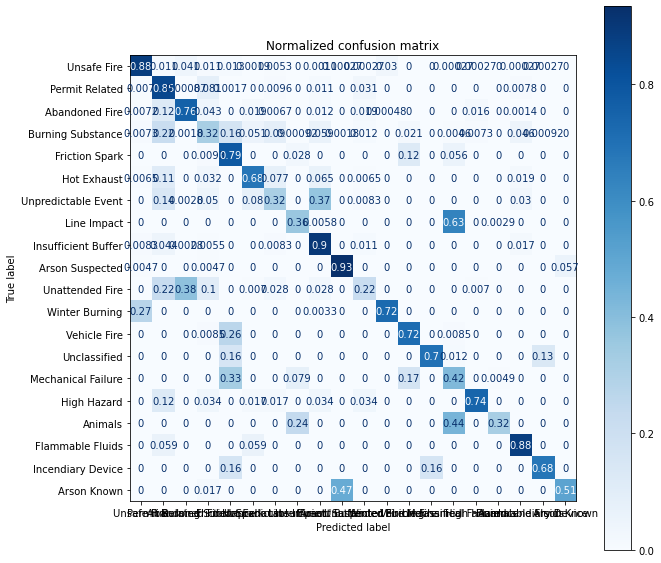

In [144]:
from sklearn.metrics import plot_confusion_matrix

model.fit(X[no_Insfficnt_Resrcs_indx], y[no_Insfficnt_Resrcs_indx].values.ravel())
class_names = y[no_Insfficnt_Resrcs_indx].unique()

# Plot non-normalized and normalized confusion matrices
titles_options = [("Normalized confusion matrix", 'true')]

fig, ax = plt.subplots(figsize=(10, 10))
for title, normalize in titles_options:
    disp = plot_confusion_matrix(model, X[no_Insfficnt_Resrcs_indx], y[no_Insfficnt_Resrcs_indx].values.ravel(),
                                 labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize, ax=ax)
    disp.ax_.set_title(title)

plt.show()

## Predicting on missing data to fill their values

In [145]:
# null fuel_type indexes for training dataset
nan_fuel_indx_train = train['true_cause'].isnull()
# null fuel_type indexes for testing dataset
nan_fuel_indx_test = test['true_cause'].isnull()

## Preprocess data
train_features = train.drop(['size_class', 'true_cause'], 1)[nan_fuel_indx_train]
test_features = test.drop(['true_cause'], 1)[nan_fuel_indx_test]

## Fill unknown data
fill_datetime_with_neighbors(train_features)
train_features.fillna('Unknown', inplace=True)

fill_datetime_with_neighbors(test_features)
test_features.fillna('Unknown', inplace=True)

## feature engineering
train_features = datetime_feature_engineering(train_features)
train_features = fire_number_feature_engineering(train_features)
train_features.drop(['fire_number'], 1, inplace=True)

test_features = datetime_feature_engineering(test_features)
test_features = fire_number_feature_engineering(test_features)
test_features.drop(['fire_number'], 1, inplace=True)

## One hot encode data
#ohe = ce.OneHotEncoder(handle_unknown='value', use_cat_names=True)
train_features = ohe.transform(train_features)
test_features = ohe.transform(test_features)

## standarized dataset
standardize = RobustScaler()
train_features[train_features.columns]=standardize.fit_transform(train_features)

standardize = RobustScaler()
test_features[test_features.columns]=standardize.fit_transform(test_features)

In [146]:
## predicting values
pred_train = model.predict(train_features)
pred_test = model.predict(test_features)

In [147]:
pd.DataFrame({'test':pred_test})['test'].value_counts()

Unsafe Fire            546
Insufficient Buffer    391
Unpredictable Event    255
Friction Spark         196
Burning Substance      139
Unclassified           125
Permit Related          62
Arson Suspected         30
Unattended Fire         26
Incendiary Device       20
High Hazard              3
Hot Exhaust              2
Mechanical Failure       1
Name: test, dtype: int64

In [148]:
pd.DataFrame({'train':pred_train})['train'].value_counts()

Unsafe Fire            2156
Insufficient Buffer    1584
Unpredictable Event    1021
Friction Spark          816
Burning Substance       614
Unclassified            441
Permit Related          192
Unattended Fire         128
Incendiary Device       116
Arson Suspected         103
High Hazard              10
Hot Exhaust               6
Abandoned Fire            3
Mechanical Failure        2
Flammable Fluids          2
Name: train, dtype: int64

In [149]:
# Saving the model
save_model('./true_cause_model.pkl', model)

In [150]:
# Loading the model
model2 = load_model('./true_cause_model.pkl')

In [151]:
test_prr = model2.predict(test_features)
pd.DataFrame({'test2':test_prr})['test2'].value_counts()

Unsafe Fire            546
Insufficient Buffer    391
Unpredictable Event    255
Friction Spark         196
Burning Substance      139
Unclassified           125
Permit Related          62
Arson Suspected         30
Unattended Fire         26
Incendiary Device       20
High Hazard              3
Hot Exhaust              2
Mechanical Failure       1
Name: test2, dtype: int64

## fill dataset and save it with model

In [152]:
## non null indexes
non_null_indx_train = ~train['true_cause'].isnull()
non_null_indx_test = ~test['true_cause'].isnull()
## null indexes
null_indx_train = train['true_cause'].isnull()
null_indx_test = test['true_cause'].isnull()

In [153]:
train.loc[null_indx_train, 'true_cause'] = model.predict(train_features)
test.loc[null_indx_test, 'true_cause'] = model.predict(test_features)

## saving data back to csv Files

In [154]:
file_name = 'train_fuel_plus_true_cause2.csv'
train.to_csv(file_name, encoding='utf-8', index=False)
file_name = 'test_fuel_plus_true_cause2.csv'
test.to_csv(file_name, encoding='utf-8', index=False)

# Fill `activity_class` feature
## Build model

In [155]:
# Loading the dataset
train = pd.read_csv('train_fuel_plus_true_cause2.csv')
test = pd.read_csv('test_fuel_plus_true_cause2.csv')
# Parsing date data to datetime type
dates_list = ['assessment_datetime', 'fire_start_date', 'discovered_date', 'reported_date', 'start_for_fire_date', 
             'fire_fighting_start_date', 'bh_fs_date', 'uc_fs_date', 'ex_fs_date']
train[dates_list]=pd.to_datetime(train[dates_list].stack(), format = "%Y-%m-%d %H:%M:%S").unstack()
test[dates_list]=pd.to_datetime(test[dates_list].stack(), format = "%Y-%m-%d %H:%M:%S").unstack()

# Train missing data
null_counts = train.isnull().sum()
null_counts[null_counts > 0].sort_values(ascending=False)

activity_class                  6197
fire_fighting_start_date        4199
discovered_date                 2119
weather_conditions_over_fire    1893
fire_position_on_slope          1888
fire_type                       1819
fire_start_date                  433
fire_origin                        7
reported_date                      1
det_agent                          1
det_agent_type                     1
dtype: int64

In [156]:
# train non null fuel indexes
nan_trueCause_indx_train = ~train['activity_class'].isnull()
# test non null fuel indexes
nan_trueCause_indx_test = ~test['activity_class'].isnull()
## join the datasets: train + test datasets
full_dataset = pd.concat([train.drop(['size_class'], 1)[nan_trueCause_indx_train], 
           test[nan_trueCause_indx_test]])
## Get the features and labels
X = full_dataset.drop(['activity_class'], 1)
y = full_dataset['activity_class']

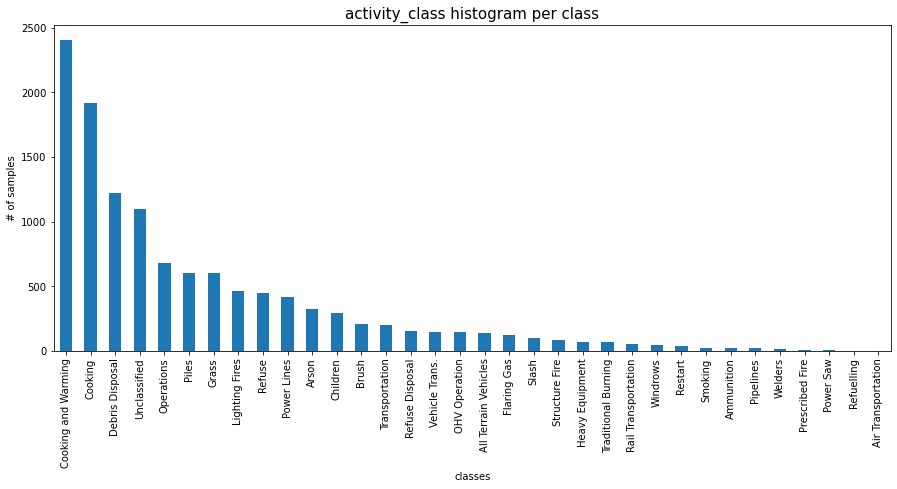

Cooking and Warming     2403
Cooking                 1914
Debris Disposal         1224
Unclassified            1097
Operations               678
Piles                    603
Grass                    601
Lighting Fires           461
Refuse                   451
Power Lines              417
Arson                    323
Children                 292
Brush                    207
Transportation           200
Refuse Disposal          153
Vehicle Trans.           149
OHV Operation            143
All Terrain Vehicles     138
Flaring Gas              126
Slash                    102
Structure Fire            82
Heavy Equipment           67
Traditional Burning       67
Rail Transportation       55
Windrows                  43
Restart                   38
Smoking                   22
Ammunition                20
Pipelines                 18
Welders                   16
Prescribed Fire            6
Power Saw                  5
Refuelling                 1
Air Transportation         1
Name: activity

In [157]:
plt.figure(figsize=(15,6))
full_dataset['activity_class'].value_counts().plot(kind='bar');
plt.title('activity_class histogram per class', fontsize=15);
plt.xlabel('classes')
plt.ylabel('# of samples');
plt.show()
full_dataset['activity_class'].value_counts()

In [158]:
## Fill unknown data
fill_datetime_with_neighbors(X)
X.fillna('Unknown', inplace=True)
## feature engineering
X = datetime_feature_engineering(X)
X = fire_number_feature_engineering(X)
X.drop(['fire_number'], 1, inplace=True)
# One hot encode data
ohe = ce.OneHotEncoder(handle_unknown='value', use_cat_names=True)
X = ohe.fit_transform(X)
# standarized dataset
standardize = RobustScaler()
X[X.columns]=standardize.fit_transform(X)
# get rid of very low classes
no_Insfficnt_Resrcs_indx = (y!='Air Transportation') & (y!='Refuelling') & (y!='Power Saw') & (y!='Prescribed Fire')
train_X, validation_X, train_y, validation_y = train_test_split(X[no_Insfficnt_Resrcs_indx], 
                                                                y[no_Insfficnt_Resrcs_indx], 
                                                                test_size=0.25, random_state=2, 
                                                                stratify=y[no_Insfficnt_Resrcs_indx])

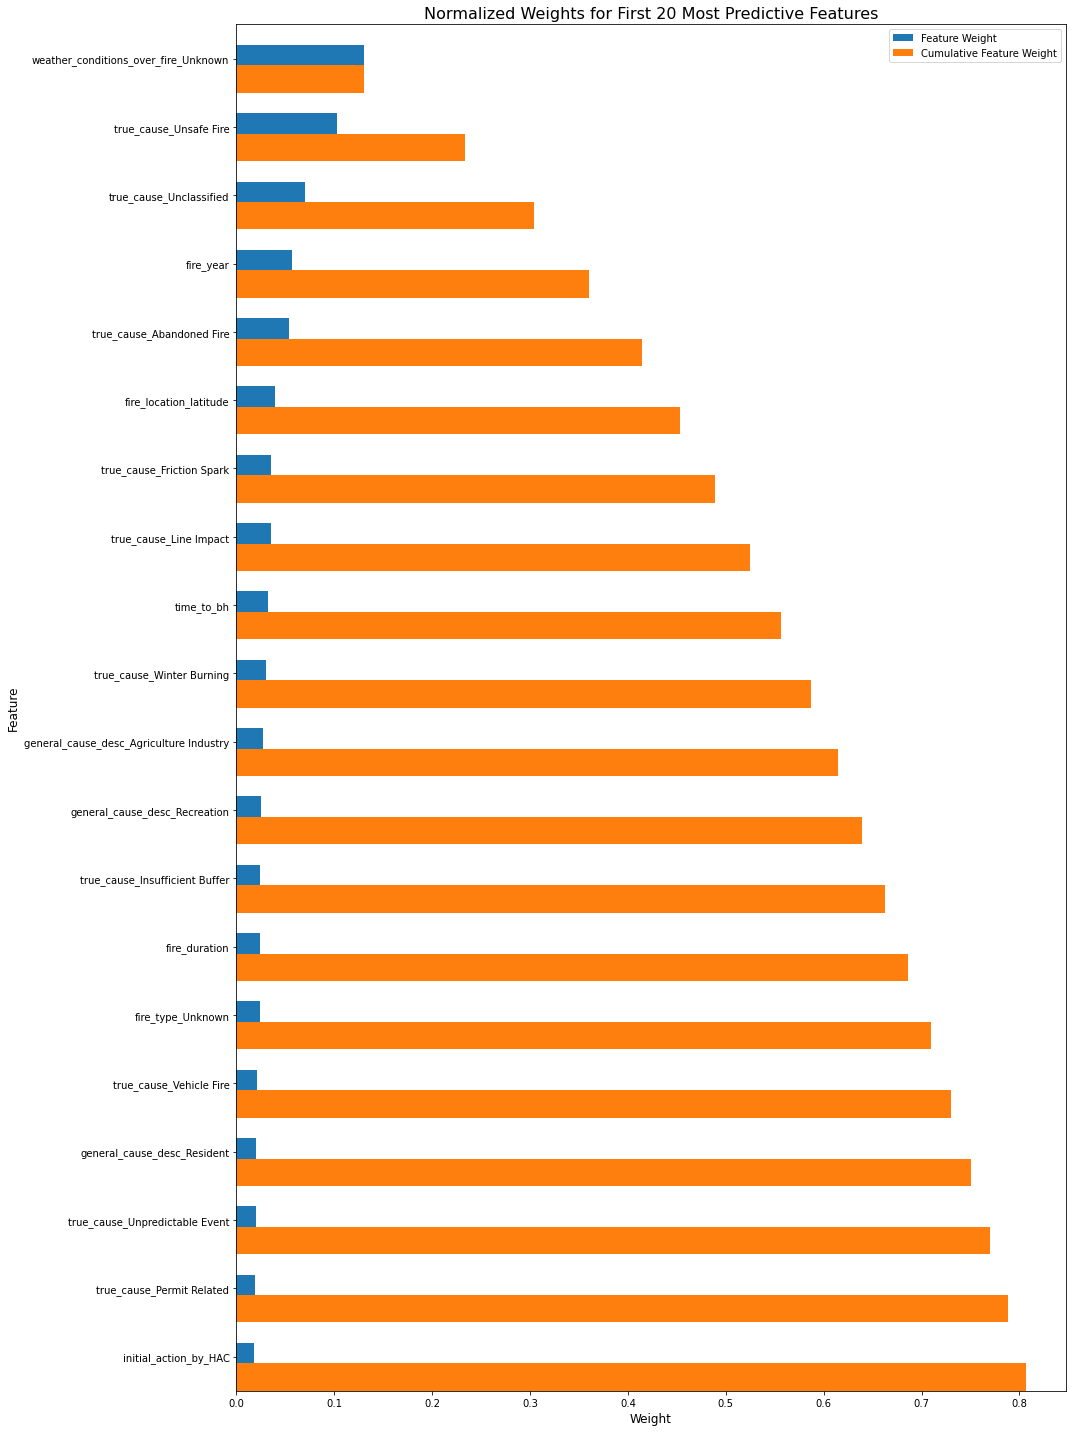

,Features,Importance value
0,weather_conditions_over_fire_Unknown,0.130609
1,true_cause_Unsafe Fire,0.102831
2,true_cause_Unclassified,0.070420
3,fire_year,0.056455
4,true_cause_Abandoned Fire,0.054117
5,fire_location_latitude,0.039042
6,true_cause_Friction Spark,0.035556
7,true_cause_Line Impact,0.035386
8,time_to_bh,0.032435
9,true_cause_Winter Burning,0.029865


In [6]:
model = GradientBoostingClassifier(random_state=42, learning_rate=0.5, n_estimators=50, 
                                   max_depth=3)
model.fit(train_X.values, train_y.values.ravel())

# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
relevant_df = feature_plot(importances, train_X, train_y, top_k=20)
relevant_df

In [159]:
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier, RUSBoostClassifier
from imblearn.metrics import geometric_mean_score
# define model
"""Best model so far"""
#model = RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced_subsample',
#                              criterion='entropy', max_features=20, min_impurity_decrease=0.003) 
""""""
#weights = {'C4': 1, 'S2': 1.8, 'S1': 3, 'D1': 3.75, 'C1': 9.6,
#           'M1': 10.8, 'C3': 11.6, 'O1b': 14.8, 'M2':15.63, 'O1a':15.72, 'C2':46.18}
#weights = {'C4': 10, 'S2': 11.8, 'S1': 14, 'D1': 15.75, 'C1': 9.6,
#           'M1': 20.8, 'C3': 17.6, 'O1b': 14.8, 'M2':29.63, 'O1a':15.72, 'C2':16.18}

#model = BalancedRandomForestClassifier(n_estimators=150, max_depth=10,
#                                       random_state=42, class_weight=weights,n_jobs = 1,
#                                      criterion='entropy', max_features=None, min_impurity_decrease=0.003
#                                      ,min_samples_leaf = 5, ccp_alpha=0.008, sampling_strategy= 'all')
#model = EasyEnsembleClassifier(base_estimator=GradientBoostingClassifier(random_state=42, learning_rate=0.5, 
#                                                                         n_estimators=100, max_depth=3,
#                                                                        max_features=15), 
#                                n_estimators=10, random_state=42)
#model = RUSBoostClassifier(random_state=42,  learning_rate=0.1, n_estimators=50)
#model = RUSBoostClassifier(base_estimator=RandomForestClassifier(class_weight = 'balanced_subsample', max_depth=10,
#                                                                criterion='entropy', max_features=15),
#                           random_state=42,  learning_rate=0.1, n_estimators=10)
model = RUSBoostClassifier(RandomForestClassifier(random_state=42, n_estimators=100, 
                                   max_depth=10, class_weight = 'balanced_subsample',
                              criterion='entropy', max_features=None, min_impurity_decrease=0.003),
                           random_state=42,  learning_rate=0.1, n_estimators=10)


# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

# evaluate model
scores = cross_val_score(model, X[no_Insfficnt_Resrcs_indx], y[no_Insfficnt_Resrcs_indx], scoring='f1_macro', cv=cv, n_jobs=-1)
#scores = cross_val_score(model, pca_X, y[no_M4_M3_C7_indx], scoring='f1_macro', cv=cv, n_jobs=-1)
# summarize performance
print('Mean f1-score: %.3f' % np.mean(scores))

Mean f1-score: 0.543


In [8]:
## Fit model
model.fit(train_X, train_y.values.ravel())

## predict using fit model
pred_validation_y = model.predict(validation_X)
f1_score = fbeta_score(validation_y.values.ravel(), pred_validation_y, beta = 1, average='macro')
gmean_score = geometric_mean_score(validation_y.values.ravel(), pred_validation_y)
gmean_score_sparse = geometric_mean_score(validation_y.values.ravel(), pred_validation_y, average=None)
print(f"F1-score - validation:{f1_score}")
print(f"Geometric mean - validation:{gmean_score}")
print(f"Geometric mean per class - validation:{gmean_score_sparse}")

print("-------------------------------------------------------------------------------------------")
pred_train_y = model.predict(train_X)
f1_score = fbeta_score(train_y.values.ravel(), pred_train_y, beta = 1, average='macro')
gmean_score = geometric_mean_score(train_y.values.ravel(), pred_train_y)
gmean_score_sparse = geometric_mean_score(train_y.values.ravel(), pred_train_y, average=None)
print(f"F1-score - train:{f1_score}")
print(f"Geometric mean - train:{gmean_score}")
print(f"Geometric mean per class - train:{gmean_score_sparse}")

F1-score - validation:0.46883930308730365
Geometric mean - validation:0.0
Geometric mean per class - validation:[0.94977193 0.89324291 0.41573971 0.63652525 0.9107903  0.93935721
 0.98828411 0.75616306 0.63705825 0.50759349 0.5409736  0.99024481
 0.93505698 0.84262768 0.34454041 0.49884125 0.9847971  0.96362411
 0.2101711  0.80086975 0.81582017 0.44144286 0.         0.96294374
 0.59389119 0.42376514 0.83443703 0.76838786 0.         0.79295038]
-------------------------------------------------------------------------------------------
F1-score - train:0.5489181232374192
Geometric mean - train:0.564942354862716
Geometric mean per class - train:[0.90860307 0.89289686 0.5061604  0.7008009  0.91622518 0.9396455
 0.98708609 0.76107114 0.71431128 0.49633831 0.75980453 0.99474311
 0.9148315  0.86805825 0.41711978 0.92413396 0.98333472 0.99988939
 0.27179303 0.7535217  0.90896368 0.74642534 0.48504449 0.934415
 0.70691103 0.54744654 0.85076019 0.69126175 0.86550009 0.87859365]


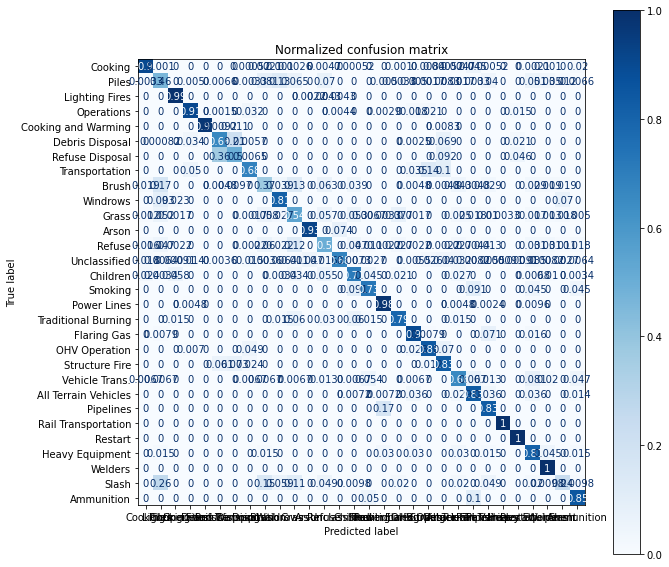

In [160]:
from sklearn.metrics import plot_confusion_matrix

model.fit(X[no_Insfficnt_Resrcs_indx], y[no_Insfficnt_Resrcs_indx].values.ravel())

class_names = validation_y.unique()

# Plot non-normalized and normalized confusion matrices
titles_options = [("Normalized confusion matrix", 'true')]

fig, ax = plt.subplots(figsize=(10, 10))
for title, normalize in titles_options:
    disp = plot_confusion_matrix(model, X[no_Insfficnt_Resrcs_indx], y[no_Insfficnt_Resrcs_indx].values.ravel(),
                                 labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize, ax=ax)
    disp.ax_.set_title(title)

plt.show()

In [161]:
# null fuel_type indexes for training dataset
nan_fuel_indx_train = train['activity_class'].isnull()
# null fuel_type indexes for testing dataset
nan_fuel_indx_test = test['activity_class'].isnull()

## Preprocess data
train_features = train.drop(['size_class', 'activity_class'], 1)[nan_fuel_indx_train]
test_features = test.drop(['activity_class'], 1)[nan_fuel_indx_test]

## Fill unknown data
fill_datetime_with_neighbors(train_features)
train_features.fillna('Unknown', inplace=True)

fill_datetime_with_neighbors(test_features)
test_features.fillna('Unknown', inplace=True)

## feature engineering
train_features = datetime_feature_engineering(train_features)
train_features = fire_number_feature_engineering(train_features)
train_features.drop(['fire_number'], 1, inplace=True)

test_features = datetime_feature_engineering(test_features)
test_features = fire_number_feature_engineering(test_features)
test_features.drop(['fire_number'], 1, inplace=True)

## One hot encode data
#ohe = ce.OneHotEncoder(handle_unknown='value', use_cat_names=True)
train_features = ohe.transform(train_features)
test_features = ohe.transform(test_features)

## standarized dataset
standardize = RobustScaler()
train_features[train_features.columns]=standardize.fit_transform(train_features)

standardize = RobustScaler()
test_features[test_features.columns]=standardize.fit_transform(test_features)

In [162]:
## predicting values
pred_train = model.predict(train_features)
pred_test = model.predict(test_features)

In [163]:
pd.DataFrame({'test':pred_test})['test'].value_counts()

Debris Disposal         493
Heavy Equipment         482
Operations              252
Pipelines               138
Piles                    68
Transportation           40
OHV Operation            11
Ammunition               11
Brush                     8
Power Lines               5
Slash                     4
Vehicle Trans.            4
All Terrain Vehicles      3
Refuse                    3
Smoking                   1
Rail Transportation       1
Name: test, dtype: int64

In [164]:
pd.DataFrame({'train':pred_train})['train'].value_counts()

Heavy Equipment         2012
Debris Disposal         1987
Operations              1083
Pipelines                525
Transportation           190
Piles                    180
Ammunition                50
Brush                     50
OHV Operation             38
Vehicle Trans.            31
Slash                     15
Refuse                    10
All Terrain Vehicles       9
Power Lines                6
Cooking                    3
Lighting Fires             2
Flaring Gas                2
Welders                    2
Refuse Disposal            1
Rail Transportation        1
Name: train, dtype: int64

In [165]:
# Saving the model
save_model('./activity_class_model.pkl', model)

In [166]:
# Loading the model
model2 = load_model('./activity_class_model.pkl')

In [167]:
test_prr = model2.predict(test_features)
pd.DataFrame({'test2':test_prr})['test2'].value_counts()

Debris Disposal         493
Heavy Equipment         482
Operations              252
Pipelines               138
Piles                    68
Transportation           40
OHV Operation            11
Ammunition               11
Brush                     8
Power Lines               5
Slash                     4
Vehicle Trans.            4
All Terrain Vehicles      3
Refuse                    3
Smoking                   1
Rail Transportation       1
Name: test2, dtype: int64

## fill dataset and save it with model

In [168]:
## non null indexes
non_null_indx_train = ~train['activity_class'].isnull()
non_null_indx_test = ~test['activity_class'].isnull()
## null indexes
null_indx_train = train['activity_class'].isnull()
null_indx_test = test['activity_class'].isnull()

In [169]:
train.loc[null_indx_train, 'activity_class'] = model.predict(train_features)
test.loc[null_indx_test, 'activity_class'] = model.predict(test_features)

## saving data back to csv Files

In [170]:
file_name = 'train_fuel_plus_true_cause_plus_activity_class2.csv'
train.to_csv(file_name, encoding='utf-8', index=False)
file_name = 'test_fuel_plus_true_cause_plus_activity_class2.csv'
test.to_csv(file_name, encoding='utf-8', index=False)

# Fill `weather_conditions_over_fire` feature
## Build model

In [171]:
# Loading the dataset
train = pd.read_csv('train_fuel_plus_true_cause_plus_activity_class2.csv')
test = pd.read_csv('test_fuel_plus_true_cause_plus_activity_class2.csv')
# Parsing date data to datetime type
dates_list = ['assessment_datetime', 'fire_start_date', 'discovered_date', 'reported_date', 'start_for_fire_date', 
             'fire_fighting_start_date', 'bh_fs_date', 'uc_fs_date', 'ex_fs_date']
train[dates_list]=pd.to_datetime(train[dates_list].stack(), format = "%Y-%m-%d %H:%M:%S").unstack()
test[dates_list]=pd.to_datetime(test[dates_list].stack(), format = "%Y-%m-%d %H:%M:%S").unstack()

# Train missing data
null_counts = train.isnull().sum()
null_counts[null_counts > 0].sort_values(ascending=False)

fire_fighting_start_date        4199
discovered_date                 2119
weather_conditions_over_fire    1893
fire_position_on_slope          1888
fire_type                       1819
fire_start_date                  433
fire_origin                        7
reported_date                      1
det_agent                          1
det_agent_type                     1
dtype: int64

In [172]:
# train non null fuel indexes
nan_trueCause_indx_train = ~train['weather_conditions_over_fire'].isnull()
# test non null fuel indexes
nan_trueCause_indx_test = ~test['weather_conditions_over_fire'].isnull()
## join the datasets: train + test datasets
full_dataset = pd.concat([train.drop(['size_class'], 1)[nan_trueCause_indx_train], 
           test[nan_trueCause_indx_test]])
## Get the features and labels
X = full_dataset.drop(['weather_conditions_over_fire'], 1)
y = full_dataset['weather_conditions_over_fire']

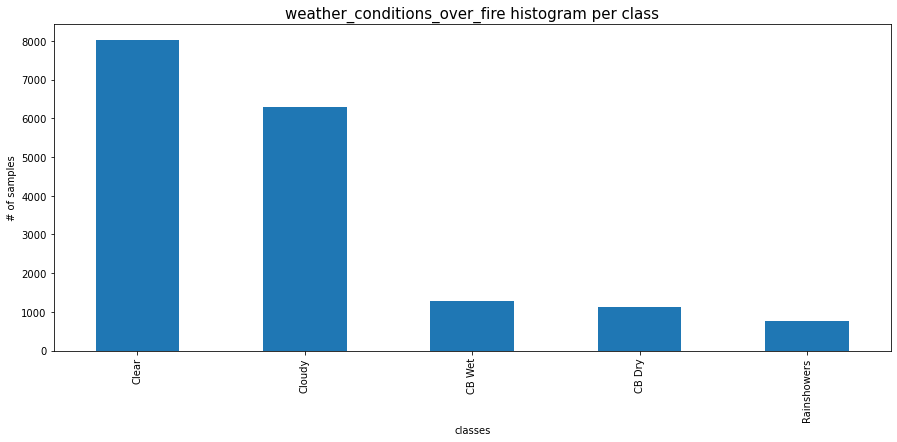

Clear          8024
Cloudy         6291
CB Wet         1292
CB Dry         1137
Rainshowers     751
Name: weather_conditions_over_fire, dtype: int64

In [173]:
plt.figure(figsize=(15,6))
full_dataset['weather_conditions_over_fire'].value_counts().plot(kind='bar');
plt.title('weather_conditions_over_fire histogram per class', fontsize=15);
plt.xlabel('classes')
plt.ylabel('# of samples');
plt.show()
full_dataset['weather_conditions_over_fire'].value_counts()

In [174]:
## Fill unknown data
fill_datetime_with_neighbors(X)
X.fillna('Unknown', inplace=True)
## feature engineering
X = datetime_feature_engineering(X)
X = fire_number_feature_engineering(X)
X.drop(['fire_number'], 1, inplace=True)
# One hot encode data
ohe = ce.OneHotEncoder(handle_unknown='value', use_cat_names=True)
X = ohe.fit_transform(X)
# standarized dataset
standardize = RobustScaler()
X[X.columns]=standardize.fit_transform(X)
# get rid of very low classes
no_Insfficnt_Resrcs_indx = (y!='Dummy')# & (y!='Refuelling') & (y!='Power Saw') & (y!='Prescribed Fire')
train_X, validation_X, train_y, validation_y = train_test_split(X[no_Insfficnt_Resrcs_indx], 
                                                                y[no_Insfficnt_Resrcs_indx], 
                                                                test_size=0.25, random_state=2, 
                                                                stratify=y[no_Insfficnt_Resrcs_indx])

In [175]:
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier, RUSBoostClassifier
from imblearn.metrics import geometric_mean_score
# define model
"""Best model so far"""
#model = RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced_subsample',
#                              criterion='entropy', max_features=20, min_impurity_decrease=0.003) 
""""""
#weights = {'C4': 1, 'S2': 1.8, 'S1': 3, 'D1': 3.75, 'C1': 9.6,
#           'M1': 10.8, 'C3': 11.6, 'O1b': 14.8, 'M2':15.63, 'O1a':15.72, 'C2':46.18}
#weights = {'C4': 10, 'S2': 11.8, 'S1': 14, 'D1': 15.75, 'C1': 9.6,
#           'M1': 20.8, 'C3': 17.6, 'O1b': 14.8, 'M2':29.63, 'O1a':15.72, 'C2':16.18}

#model = BalancedRandomForestClassifier(n_estimators=150, max_depth=10,
#                                       random_state=42, class_weight=weights,n_jobs = 1,
#                                      criterion='entropy', max_features=None, min_impurity_decrease=0.003
#                                      ,min_samples_leaf = 5, ccp_alpha=0.008, sampling_strategy= 'all')
#model = EasyEnsembleClassifier(base_estimator=GradientBoostingClassifier(random_state=42, learning_rate=0.5, 
#                                                                         n_estimators=100, max_depth=3,
#                                                                        max_features=15), 
#                                n_estimators=10, random_state=42)
#model = RUSBoostClassifier(random_state=42,  learning_rate=0.1, n_estimators=50)
#model = RUSBoostClassifier(base_estimator=RandomForestClassifier(class_weight = 'balanced_subsample', max_depth=10,
#                                                                criterion='entropy', max_features=15),
#                           random_state=42,  learning_rate=0.1, n_estimators=10)
model = RUSBoostClassifier(RandomForestClassifier(random_state=42, n_estimators=100, 
                                   max_depth=10, class_weight = 'balanced_subsample',
                              criterion='entropy', max_features=None, min_impurity_decrease=0.003),
                           random_state=42,  learning_rate=0.1, n_estimators=10)


# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

# evaluate model
scores = cross_val_score(model, X[no_Insfficnt_Resrcs_indx], y[no_Insfficnt_Resrcs_indx], scoring='f1_macro', cv=cv, n_jobs=-1)
#scores = cross_val_score(model, pca_X, y[no_M4_M3_C7_indx], scoring='f1_macro', cv=cv, n_jobs=-1)
# summarize performance
print('Mean f1-score: %.3f' % np.mean(scores))

Mean f1-score: 0.316


In [89]:
## Fit model
model.fit(train_X, train_y.values.ravel())

## predict using fit model
pred_validation_y = model.predict(validation_X)
f1_score = fbeta_score(validation_y.values.ravel(), pred_validation_y, beta = 1, average='macro')
gmean_score = geometric_mean_score(validation_y.values.ravel(), pred_validation_y)
gmean_score_sparse = geometric_mean_score(validation_y.values.ravel(), pred_validation_y, average=None)
print(f"F1-score - validation:{f1_score}")
print(f"Geometric mean - validation:{gmean_score}")
print(f"Geometric mean per class - validation:{gmean_score_sparse}")

print("-------------------------------------------------------------------------------------------")
pred_train_y = model.predict(train_X)
f1_score = fbeta_score(train_y.values.ravel(), pred_train_y, beta = 1, average='macro')
gmean_score = geometric_mean_score(train_y.values.ravel(), pred_train_y)
gmean_score_sparse = geometric_mean_score(train_y.values.ravel(), pred_train_y, average=None)
print(f"F1-score - train:{f1_score}")
print(f"Geometric mean - train:{gmean_score}")
print(f"Geometric mean per class - train:{gmean_score_sparse}")

F1-score - validation:0.32354427172848793
Geometric mean - validation:0.35324518487472345
Geometric mean per class - validation:[0.49405885 0.77048339 0.60257386 0.46343019 0.44215778]
-------------------------------------------------------------------------------------------
F1-score - train:0.4153389619980755
Geometric mean - train:0.49082786312363624
Geometric mean per class - train:[0.6244879  0.80817495 0.6203803  0.51074762 0.69867148]


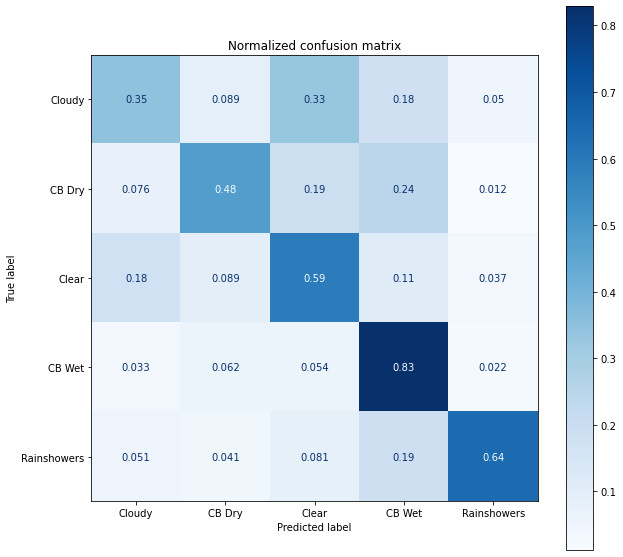

In [176]:
from sklearn.metrics import plot_confusion_matrix
model.fit(X[no_Insfficnt_Resrcs_indx], y[no_Insfficnt_Resrcs_indx].values.ravel())
class_names = y[no_Insfficnt_Resrcs_indx].unique()

# Plot non-normalized and normalized confusion matrices
titles_options = [("Normalized confusion matrix", 'true')]

fig, ax = plt.subplots(figsize=(10, 10))
for title, normalize in titles_options:
    disp = plot_confusion_matrix(model, X[no_Insfficnt_Resrcs_indx], y[no_Insfficnt_Resrcs_indx].values.ravel(),
                                 labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize, ax=ax)
    disp.ax_.set_title(title)

plt.show()

In [177]:
# null fuel_type indexes for training dataset
nan_fuel_indx_train = train['weather_conditions_over_fire'].isnull()
# null fuel_type indexes for testing dataset
nan_fuel_indx_test = test['weather_conditions_over_fire'].isnull()

## Preprocess data
train_features = train.drop(['size_class', 'weather_conditions_over_fire'], 1)[nan_fuel_indx_train]
test_features = test.drop(['weather_conditions_over_fire'], 1)[nan_fuel_indx_test]

## Fill unknown data
fill_datetime_with_neighbors(train_features)
train_features.fillna('Unknown', inplace=True)

fill_datetime_with_neighbors(test_features)
test_features.fillna('Unknown', inplace=True)

## feature engineering
train_features = datetime_feature_engineering(train_features)
train_features = fire_number_feature_engineering(train_features)
train_features.drop(['fire_number'], 1, inplace=True)

test_features = datetime_feature_engineering(test_features)
test_features = fire_number_feature_engineering(test_features)
test_features.drop(['fire_number'], 1, inplace=True)

## One hot encode data
#ohe = ce.OneHotEncoder(handle_unknown='value', use_cat_names=True)
train_features = ohe.transform(train_features)
test_features = ohe.transform(test_features)

## standarized dataset
standardize = RobustScaler()
train_features[train_features.columns]=standardize.fit_transform(train_features)

standardize = RobustScaler()
test_features[test_features.columns]=standardize.fit_transform(test_features)

In [178]:
## predicting values
pred_train = model.predict(train_features)
pred_test = model.predict(test_features)

In [179]:
pd.DataFrame({'test':pred_test})['test'].value_counts()

Clear     371
Cloudy     85
Name: test, dtype: int64

In [180]:
pd.DataFrame({'train':pred_train})['train'].value_counts()

Clear     1530
Cloudy     363
Name: train, dtype: int64

In [181]:
# Saving the model
save_model('./weather_conditions_over_fire_model.pkl', model)

In [182]:
# Loading the model
model2 = load_model('./weather_conditions_over_fire_model.pkl')

In [183]:
test_prr = model2.predict(test_features)
pd.DataFrame({'test2':test_prr})['test2'].value_counts()

Clear     371
Cloudy     85
Name: test2, dtype: int64

## fill dataset and save it with model

In [184]:
## non null indexes
non_null_indx_train = ~train['weather_conditions_over_fire'].isnull()
non_null_indx_test = ~test['weather_conditions_over_fire'].isnull()
## null indexes
null_indx_train = train['weather_conditions_over_fire'].isnull()
null_indx_test = test['weather_conditions_over_fire'].isnull()

In [185]:
train.loc[null_indx_train, 'weather_conditions_over_fire'] = model.predict(train_features)
test.loc[null_indx_test, 'weather_conditions_over_fire'] = model.predict(test_features)

## saving data back to csv Files

In [186]:
file_name = 'train_fuel_pp_true_cause_pp_activity_class_pp_weather_conditions_over_fire2.csv'
train.to_csv(file_name, encoding='utf-8', index=False)
file_name = 'test_fuel_pp_true_cause_pp_activity_class_pp_weather_conditions_over_fire2.csv'
test.to_csv(file_name, encoding='utf-8', index=False)

# Fill `fire_position_on_slope` feature
## Build model

In [187]:
# Loading the dataset
train = pd.read_csv('train_fuel_pp_true_cause_pp_activity_class_pp_weather_conditions_over_fire2.csv')
test = pd.read_csv('test_fuel_pp_true_cause_pp_activity_class_pp_weather_conditions_over_fire2.csv')
# Parsing date data to datetime type
dates_list = ['assessment_datetime', 'fire_start_date', 'discovered_date', 'reported_date', 'start_for_fire_date', 
             'fire_fighting_start_date', 'bh_fs_date', 'uc_fs_date', 'ex_fs_date']
train[dates_list]=pd.to_datetime(train[dates_list].stack(), format = "%Y-%m-%d %H:%M:%S").unstack()
test[dates_list]=pd.to_datetime(test[dates_list].stack(), format = "%Y-%m-%d %H:%M:%S").unstack()

# Train missing data
null_counts = train.isnull().sum()
null_counts[null_counts > 0].sort_values(ascending=False)

fire_fighting_start_date    4199
discovered_date             2119
fire_position_on_slope      1888
fire_type                   1819
fire_start_date              433
fire_origin                    7
reported_date                  1
det_agent                      1
det_agent_type                 1
dtype: int64

In [188]:
# train non null fuel indexes
nan_trueCause_indx_train = ~train['fire_position_on_slope'].isnull()
# test non null fuel indexes
nan_trueCause_indx_test = ~test['fire_position_on_slope'].isnull()
## join the datasets: train + test datasets
full_dataset = pd.concat([train.drop(['size_class'], 1)[nan_trueCause_indx_train], 
           test[nan_trueCause_indx_test]])
## Get the features and labels
X = full_dataset.drop(['fire_position_on_slope'], 1)
y = full_dataset['fire_position_on_slope']

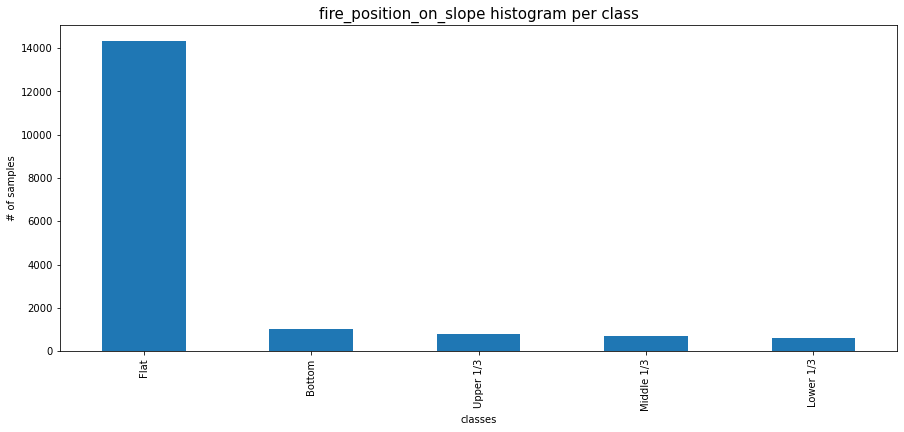

Flat          14346
Bottom         1046
Upper 1/3       800
Middle 1/3      708
Lower 1/3       600
Name: fire_position_on_slope, dtype: int64

In [189]:
plt.figure(figsize=(15,6))
full_dataset['fire_position_on_slope'].value_counts().plot(kind='bar');
plt.title('fire_position_on_slope histogram per class', fontsize=15);
plt.xlabel('classes')
plt.ylabel('# of samples');
plt.show()
full_dataset['fire_position_on_slope'].value_counts()

In [190]:
## Fill unknown data
fill_datetime_with_neighbors(X)
X.fillna('Unknown', inplace=True)
## feature engineering
X = datetime_feature_engineering(X)
X = fire_number_feature_engineering(X)
X.drop(['fire_number'], 1, inplace=True)
# One hot encode data
ohe = ce.OneHotEncoder(handle_unknown='value', use_cat_names=True)
X = ohe.fit_transform(X)
# standarized dataset
standardize = RobustScaler()
X[X.columns]=standardize.fit_transform(X)
# get rid of very low classes
no_Insfficnt_Resrcs_indx = (y!='Dummy')# & (y!='Refuelling') & (y!='Power Saw') & (y!='Prescribed Fire')
train_X, validation_X, train_y, validation_y = train_test_split(X[no_Insfficnt_Resrcs_indx], 
                                                                y[no_Insfficnt_Resrcs_indx], 
                                                                test_size=0.25, random_state=2, 
                                                                stratify=y[no_Insfficnt_Resrcs_indx])

In [191]:
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier, RUSBoostClassifier
from imblearn.metrics import geometric_mean_score
# define model
"""Best model so far"""
#model = RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced_subsample',
#                              criterion='entropy', max_features=20, min_impurity_decrease=0.003) 
""""""
#weights = {'C4': 1, 'S2': 1.8, 'S1': 3, 'D1': 3.75, 'C1': 9.6,
#           'M1': 10.8, 'C3': 11.6, 'O1b': 14.8, 'M2':15.63, 'O1a':15.72, 'C2':46.18}
#weights = {'C4': 10, 'S2': 11.8, 'S1': 14, 'D1': 15.75, 'C1': 9.6,
#           'M1': 20.8, 'C3': 17.6, 'O1b': 14.8, 'M2':29.63, 'O1a':15.72, 'C2':16.18}

#model = BalancedRandomForestClassifier(n_estimators=150, max_depth=10,
#                                       random_state=42, class_weight=weights,n_jobs = 1,
#                                      criterion='entropy', max_features=None, min_impurity_decrease=0.003
#                                      ,min_samples_leaf = 5, ccp_alpha=0.008, sampling_strategy= 'all')
#model = EasyEnsembleClassifier(base_estimator=GradientBoostingClassifier(random_state=42, learning_rate=0.5, 
#                                                                         n_estimators=100, max_depth=3,
#                                                                        max_features=15), 
#                                n_estimators=10, random_state=42)
#model = RUSBoostClassifier(random_state=42,  learning_rate=0.1, n_estimators=50)
#model = RUSBoostClassifier(base_estimator=RandomForestClassifier(class_weight = 'balanced_subsample', max_depth=10,
#                                                                criterion='entropy', max_features=15),
#                           random_state=42,  learning_rate=0.1, n_estimators=10)
model = RUSBoostClassifier(RandomForestClassifier(random_state=42, n_estimators=100, 
                                   max_depth=10, class_weight = 'balanced_subsample',
                              criterion='entropy', max_features=None, min_impurity_decrease=0.003),
                           random_state=42,  learning_rate=0.1, n_estimators=10)


# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

# evaluate model
scores = cross_val_score(model, X[no_Insfficnt_Resrcs_indx], y[no_Insfficnt_Resrcs_indx], scoring='f1_macro', cv=cv, n_jobs=-1)
#scores = cross_val_score(model, pca_X, y[no_M4_M3_C7_indx], scoring='f1_macro', cv=cv, n_jobs=-1)
# summarize performance
print('Mean f1-score: %.3f' % np.mean(scores))

Mean f1-score: 0.271


In [31]:
## Fit model
model.fit(train_X, train_y.values.ravel())

## predict using fit model
pred_validation_y = model.predict(validation_X)
f1_score = fbeta_score(validation_y.values.ravel(), pred_validation_y, beta = 1, average='macro')
gmean_score = geometric_mean_score(validation_y.values.ravel(), pred_validation_y)
gmean_score_sparse = geometric_mean_score(validation_y.values.ravel(), pred_validation_y, average=None)
print(f"F1-score - validation:{f1_score}")
print(f"Geometric mean - validation:{gmean_score}")
print(f"Geometric mean per class - validation:{gmean_score_sparse}")

print("-------------------------------------------------------------------------------------------")
pred_train_y = model.predict(train_X)
f1_score = fbeta_score(train_y.values.ravel(), pred_train_y, beta = 1, average='macro')
gmean_score = geometric_mean_score(train_y.values.ravel(), pred_train_y)
gmean_score_sparse = geometric_mean_score(train_y.values.ravel(), pred_train_y, average=None)
print(f"F1-score - train:{f1_score}")
print(f"Geometric mean - train:{gmean_score}")
print(f"Geometric mean per class - train:{gmean_score_sparse}")

F1-score - validation:0.2685954147208303
Geometric mean - validation:0.3281639443282768
Geometric mean per class - validation:[0.55312029 0.66161083 0.44142141 0.50800871 0.51478732]
-------------------------------------------------------------------------------------------
F1-score - train:0.5322469325477341
Geometric mean - train:0.8213244913545462
Geometric mean per class - train:[0.83116097 0.75394053 0.95024391 0.91906378 0.89897332]


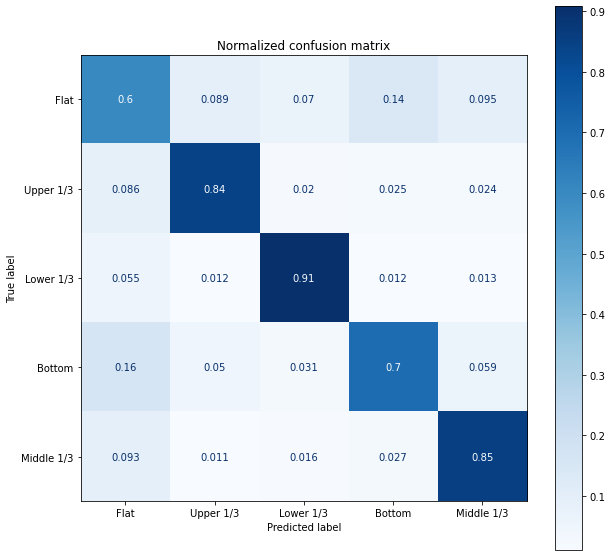

In [192]:
from sklearn.metrics import plot_confusion_matrix

model.fit(X[no_Insfficnt_Resrcs_indx], y[no_Insfficnt_Resrcs_indx].values.ravel())
class_names = y[no_Insfficnt_Resrcs_indx].unique()

# Plot non-normalized and normalized confusion matrices
titles_options = [("Normalized confusion matrix", 'true')]

fig, ax = plt.subplots(figsize=(10, 10))
for title, normalize in titles_options:
    disp = plot_confusion_matrix(model, X[no_Insfficnt_Resrcs_indx], y[no_Insfficnt_Resrcs_indx].values.ravel(),
                                 labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize, ax=ax)
    disp.ax_.set_title(title)

plt.show()

In [193]:
# null fuel_type indexes for training dataset
nan_fuel_indx_train = train['fire_position_on_slope'].isnull()
# null fuel_type indexes for testing dataset
nan_fuel_indx_test = test['fire_position_on_slope'].isnull()

## Preprocess data
train_features = train.drop(['size_class', 'fire_position_on_slope'], 1)[nan_fuel_indx_train]
test_features = test.drop(['fire_position_on_slope'], 1)[nan_fuel_indx_test]

## Fill unknown data
fill_datetime_with_neighbors(train_features)
train_features.fillna('Unknown', inplace=True)

fill_datetime_with_neighbors(test_features)
test_features.fillna('Unknown', inplace=True)

## feature engineering
train_features = datetime_feature_engineering(train_features)
train_features = fire_number_feature_engineering(train_features)
train_features.drop(['fire_number'], 1, inplace=True)

test_features = datetime_feature_engineering(test_features)
test_features = fire_number_feature_engineering(test_features)
test_features.drop(['fire_number'], 1, inplace=True)

## One hot encode data
#ohe = ce.OneHotEncoder(handle_unknown='value', use_cat_names=True)
train_features = ohe.transform(train_features)
test_features = ohe.transform(test_features)

## standarized dataset
standardize = RobustScaler()
train_features[train_features.columns]=standardize.fit_transform(train_features)

standardize = RobustScaler()
test_features[test_features.columns]=standardize.fit_transform(test_features)

In [194]:
## predicting values
pred_train = model.predict(train_features)
pred_test = model.predict(test_features)

In [195]:
pd.DataFrame({'test':pred_test})['test'].value_counts()

Flat          236
Bottom        122
Upper 1/3      46
Middle 1/3     28
Lower 1/3      24
Name: test, dtype: int64

In [196]:
pd.DataFrame({'train':pred_train})['train'].value_counts()

Flat          977
Bottom        491
Upper 1/3     192
Middle 1/3    130
Lower 1/3      98
Name: train, dtype: int64

In [200]:
# Saving the model
save_model('./fire_position_on_slope_model.pkl', model)

In [201]:
# Loading the model
model2 = load_model('./fire_position_on_slope_model.pkl')

In [202]:
test_prr = model2.predict(test_features)
pd.DataFrame({'test2':test_prr})['test2'].value_counts()

Flat          236
Bottom        122
Upper 1/3      46
Middle 1/3     28
Lower 1/3      24
Name: test2, dtype: int64

## fill dataset and save it with model

In [203]:
## non null indexes
non_null_indx_train = ~train['fire_position_on_slope'].isnull()
non_null_indx_test = ~test['fire_position_on_slope'].isnull()
## null indexes
null_indx_train = train['fire_position_on_slope'].isnull()
null_indx_test = test['fire_position_on_slope'].isnull()

In [204]:
train.loc[null_indx_train, 'fire_position_on_slope'] = model.predict(train_features)
test.loc[null_indx_test, 'fire_position_on_slope'] = model.predict(test_features)

## saving data back to csv Files

In [205]:
file_name = 'train_fuel_pp_true_cause_pp_activity_class_pp_weather_conditions_pp_fire_posSlope2.csv'
train.to_csv(file_name, encoding='utf-8', index=False)
file_name = 'test_fuel_pp_true_cause_pp_activity_class_pp_weather_conditions_pp_fire_posSlope2.csv'
test.to_csv(file_name, encoding='utf-8', index=False)

# Fill `fire_type` feature
## Build model

In [212]:
# Loading the dataset
train = pd.read_csv('train_fuel_pp_true_cause_pp_activity_class_pp_weather_conditions_pp_fire_posSlope2.csv')
test = pd.read_csv('test_fuel_pp_true_cause_pp_activity_class_pp_weather_conditions_pp_fire_posSlope2.csv')
# Parsing date data to datetime type
dates_list = ['assessment_datetime', 'fire_start_date', 'discovered_date', 'reported_date', 'start_for_fire_date', 
             'fire_fighting_start_date', 'bh_fs_date', 'uc_fs_date', 'ex_fs_date']
train[dates_list]=pd.to_datetime(train[dates_list].stack(), format = "%Y-%m-%d %H:%M:%S").unstack()
test[dates_list]=pd.to_datetime(test[dates_list].stack(), format = "%Y-%m-%d %H:%M:%S").unstack()

# Train missing data
null_counts = train.isnull().sum()
null_counts[null_counts > 0].sort_values(ascending=False)

fire_fighting_start_date    4199
discovered_date             2119
fire_type                   1819
fire_start_date              433
fire_origin                    7
reported_date                  1
det_agent                      1
det_agent_type                 1
dtype: int64

In [213]:
# train non null fuel indexes
nan_trueCause_indx_train = ~train['fire_type'].isnull()
# test non null fuel indexes
nan_trueCause_indx_test = ~test['fire_type'].isnull()
## join the datasets: train + test datasets
full_dataset = pd.concat([train.drop(['size_class'], 1)[nan_trueCause_indx_train], 
           test[nan_trueCause_indx_test]])
## Get the features and labels
X = full_dataset.drop(['fire_type'], 1)
y = full_dataset['fire_type']

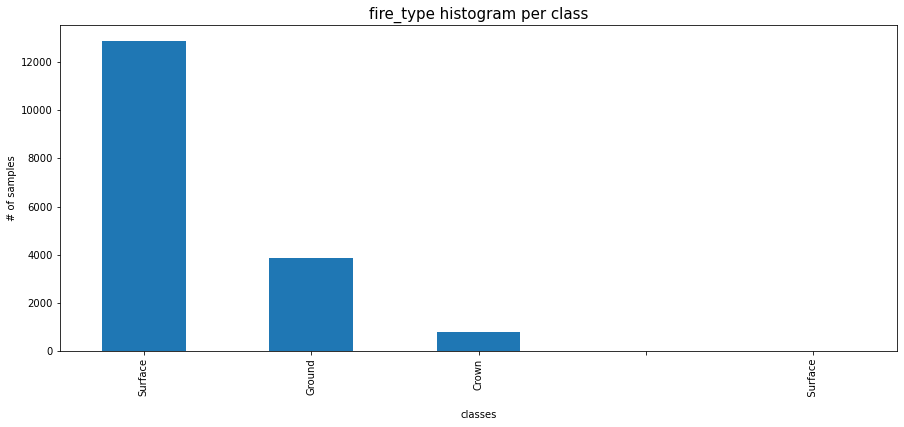

Surface       12882
Ground         3886
Crown           821
                  1
   Surface        1
Name: fire_type, dtype: int64

In [214]:
plt.figure(figsize=(15,6))
full_dataset['fire_type'].value_counts().plot(kind='bar');
plt.title('fire_type histogram per class', fontsize=15);
plt.xlabel('classes')
plt.ylabel('# of samples');
plt.show()
full_dataset['fire_type'].value_counts()

In [215]:
## Fill unknown data
fill_datetime_with_neighbors(X)
X.fillna('Unknown', inplace=True)
## feature engineering
X = datetime_feature_engineering(X)
X = fire_number_feature_engineering(X)
X.drop(['fire_number'], 1, inplace=True)
# One hot encode data
ohe = ce.OneHotEncoder(handle_unknown='value', use_cat_names=True)
X = ohe.fit_transform(X)
# standarized dataset
standardize = RobustScaler()
X[X.columns]=standardize.fit_transform(X)
# get rid of very low classes
no_Insfficnt_Resrcs_indx = (y!='  ') & (y!='   Surface')
train_X, validation_X, train_y, validation_y = train_test_split(X[no_Insfficnt_Resrcs_indx], 
                                                                y[no_Insfficnt_Resrcs_indx], 
                                                                test_size=0.25, random_state=2, 
                                                                stratify=y[no_Insfficnt_Resrcs_indx])

In [216]:
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier, RUSBoostClassifier
from imblearn.metrics import geometric_mean_score
# define model
"""Best model so far"""
#model = RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced_subsample',
#                              criterion='entropy', max_features=20, min_impurity_decrease=0.003) 
""""""
#weights = {'C4': 1, 'S2': 1.8, 'S1': 3, 'D1': 3.75, 'C1': 9.6,
#           'M1': 10.8, 'C3': 11.6, 'O1b': 14.8, 'M2':15.63, 'O1a':15.72, 'C2':46.18}
#weights = {'C4': 10, 'S2': 11.8, 'S1': 14, 'D1': 15.75, 'C1': 9.6,
#           'M1': 20.8, 'C3': 17.6, 'O1b': 14.8, 'M2':29.63, 'O1a':15.72, 'C2':16.18}

#model = BalancedRandomForestClassifier(n_estimators=150, max_depth=10,
#                                       random_state=42, class_weight=weights,n_jobs = 1,
#                                      criterion='entropy', max_features=None, min_impurity_decrease=0.003
#                                      ,min_samples_leaf = 5, ccp_alpha=0.008, sampling_strategy= 'all')
#model = EasyEnsembleClassifier(base_estimator=GradientBoostingClassifier(random_state=42, learning_rate=0.5, 
#                                                                         n_estimators=100, max_depth=3,
#                                                                        max_features=15), 
#                                n_estimators=10, random_state=42)
#model = RUSBoostClassifier(random_state=42,  learning_rate=0.1, n_estimators=50)
#model = RUSBoostClassifier(base_estimator=RandomForestClassifier(class_weight = 'balanced_subsample', max_depth=10,
#                                                                criterion='entropy', max_features=15),
#                           random_state=42,  learning_rate=0.1, n_estimators=10)
model = RUSBoostClassifier(RandomForestClassifier(random_state=42, n_estimators=100, 
                                   max_depth=10, class_weight = 'balanced_subsample',
                              criterion='entropy', max_features=None, min_impurity_decrease=0.003),
                           random_state=42,  learning_rate=0.1, n_estimators=10)


# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

# evaluate model
scores = cross_val_score(model, X[no_Insfficnt_Resrcs_indx], y[no_Insfficnt_Resrcs_indx], scoring='f1_macro', cv=cv, n_jobs=-1)
#scores = cross_val_score(model, pca_X, y[no_M4_M3_C7_indx], scoring='f1_macro', cv=cv, n_jobs=-1)
# summarize performance
print('Mean f1-score: %.3f' % np.mean(scores))

Mean f1-score: 0.487


In [27]:
## Fit model
model.fit(train_X, train_y.values.ravel())

## predict using fit model
pred_validation_y = model.predict(validation_X)
f1_score = fbeta_score(validation_y.values.ravel(), pred_validation_y, beta = 1, average='macro')
gmean_score = geometric_mean_score(validation_y.values.ravel(), pred_validation_y)
gmean_score_sparse = geometric_mean_score(validation_y.values.ravel(), pred_validation_y, average=None)
print(f"F1-score - validation:{f1_score}")
print(f"Geometric mean - validation:{gmean_score}")
print(f"Geometric mean per class - validation:{gmean_score_sparse}")

print("-------------------------------------------------------------------------------------------")
pred_train_y = model.predict(train_X)
f1_score = fbeta_score(train_y.values.ravel(), pred_train_y, beta = 1, average='macro')
gmean_score = geometric_mean_score(train_y.values.ravel(), pred_train_y)
gmean_score_sparse = geometric_mean_score(train_y.values.ravel(), pred_train_y, average=None)
print(f"F1-score - train:{f1_score}")
print(f"Geometric mean - train:{gmean_score}")
print(f"Geometric mean per class - train:{gmean_score_sparse}")

F1-score - validation:0.4783023787418165
Geometric mean - validation:0.6301471287206466
Geometric mean per class - validation:[0.83854378 0.62907638 0.6288026 ]
-------------------------------------------------------------------------------------------
F1-score - train:0.5370980883297539
Geometric mean - train:0.7223301991081343
Geometric mean per class - train:[0.91780559 0.70658723 0.68066509]


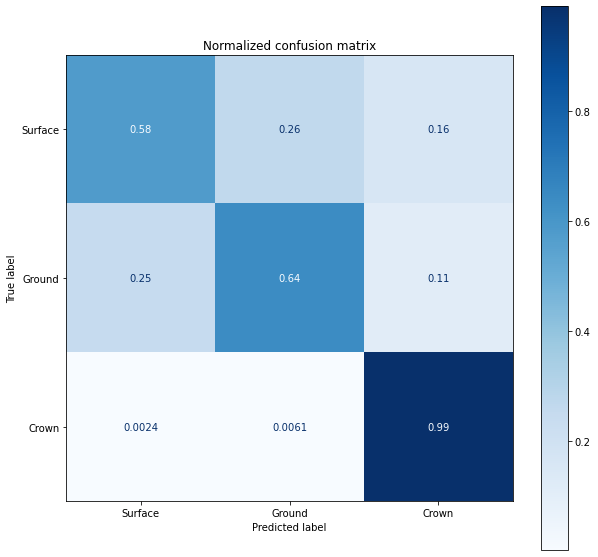

In [217]:
from sklearn.metrics import plot_confusion_matrix

model.fit(X[no_Insfficnt_Resrcs_indx], y[no_Insfficnt_Resrcs_indx].values.ravel())
class_names = y[no_Insfficnt_Resrcs_indx].unique()

# Plot non-normalized and normalized confusion matrices
titles_options = [("Normalized confusion matrix", 'true')]

fig, ax = plt.subplots(figsize=(10, 10))
for title, normalize in titles_options:
    disp = plot_confusion_matrix(model, X[no_Insfficnt_Resrcs_indx], y[no_Insfficnt_Resrcs_indx].values.ravel(),
                                 labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize, ax=ax)
    disp.ax_.set_title(title)

plt.show()

In [218]:
# null fuel_type indexes for training dataset
nan_fuel_indx_train = train['fire_type'].isnull()
# null fuel_type indexes for testing dataset
nan_fuel_indx_test = test['fire_type'].isnull()

## Preprocess data
train_features = train.drop(['size_class', 'fire_type'], 1)[nan_fuel_indx_train]
test_features = test.drop(['fire_type'], 1)[nan_fuel_indx_test]

## Fill unknown data
fill_datetime_with_neighbors(train_features)
train_features.fillna('Unknown', inplace=True)

fill_datetime_with_neighbors(test_features)
test_features.fillna('Unknown', inplace=True)

## feature engineering
train_features = datetime_feature_engineering(train_features)
train_features = fire_number_feature_engineering(train_features)
train_features.drop(['fire_number'], 1, inplace=True)

test_features = datetime_feature_engineering(test_features)
test_features = fire_number_feature_engineering(test_features)
test_features.drop(['fire_number'], 1, inplace=True)

## One hot encode data
#ohe = ce.OneHotEncoder(handle_unknown='value', use_cat_names=True)
train_features = ohe.transform(train_features)
test_features = ohe.transform(test_features)

## standarized dataset
standardize = RobustScaler()
train_features[train_features.columns]=standardize.fit_transform(train_features)

standardize = RobustScaler()
test_features[test_features.columns]=standardize.fit_transform(test_features)

In [219]:
## predicting values
pred_train = model.predict(train_features)
pred_test = model.predict(test_features)

In [220]:
pd.DataFrame({'test':pred_test})['test'].value_counts()

Ground     253
Surface    180
Crown        1
Name: test, dtype: int64

In [221]:
pd.DataFrame({'train':pred_train})['train'].value_counts()

Ground     1103
Surface     713
Crown         3
Name: train, dtype: int64

In [222]:
# Saving the model
save_model('./fire_type_model.pkl', model)

In [223]:
# Loading the model
model2 = load_model('./fire_type_model.pkl')

In [224]:
test_prr = model2.predict(test_features)
pd.DataFrame({'test2':test_prr})['test2'].value_counts()

Ground     253
Surface    180
Crown        1
Name: test2, dtype: int64

## fill dataset and save it with model

In [225]:
## non null indexes
non_null_indx_train = ~train['fire_type'].isnull()
non_null_indx_test = ~test['fire_type'].isnull()
## null indexes
null_indx_train = train['fire_type'].isnull()
null_indx_test = test['fire_type'].isnull()

In [226]:
train.loc[null_indx_train, 'fire_type'] = model.predict(train_features)
test.loc[null_indx_test, 'fire_type'] = model.predict(test_features)

## saving data back to csv Files

In [227]:
file_name = 'train_fuel_pp_true_cause_pp_activity_class_pp_weather_conditions_pp_fire_posSlope_pp_fire_type2.csv'
train.to_csv(file_name, encoding='utf-8', index=False)
file_name = 'test_fuel_pp_true_cause_pp_activity_class_pp_weather_conditions_pp_fire_posSlope_pp_fire_type2.csv'
test.to_csv(file_name, encoding='utf-8', index=False)